# Unsupervised Anomaly Detection in Time Series of Bank Transactions

## 1. Data Cleaning & Exploratory Data Analysis

In [1]:
# Data and Stats Packages
import pandas as pd
import numpy as np
import re
import datetime as dt

# Visualization Packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Anomaly Detection Packages
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore")

In [2]:
bank = pd.read_excel('Sample_bank_transaction_data.xlsx')
bank_raw = bank.copy()

In [ ]:
bank.head()

In [ ]:
bank[bank['BALANCE AMT']<0].shape

In [ ]:
bank[bank['WITHDRAWAL AMT']<0].shape

In [ ]:
bank[bank['DEPOSIT AMT']<0].shape

In [ ]:
bank.shape

In [ ]:
bank.describe()

In [3]:
bank.rename(columns={'Account No': 'account_no', 'DATE':'date', 'TRANSACTION DETAILS':'details', 'CHQ.NO.':'chq_no', 'VALUE DATE':'value_date',
       'WITHDRAWAL AMT':'withdrawal_amt', 'DEPOSIT AMT':'deposit_amt', 'BALANCE AMT':'balance_amt'}, inplace=True)
bank.head(3)

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.


We have a time series data without anomaly labeling. Let's take a closer look at the features.

In [ ]:
def first_look(df, col):
    """
    Enables a quick search for characteristics of a column in a data frame.
    
    df: Data Frame
    col: Column of interest
    
    """
    val = pd.DataFrame(df[col].value_counts(dropna=False))
    val = val.assign(percent=(df[col].value_counts(dropna=False, normalize=True).values)*100)
    info = pd.DataFrame({'Column_Name': [col],'Null_Rows': [df[col].isna().sum()], 'Column_Type': [df[col].dtypes]}, index=['column_info'])
    return info, val

### i. account_no

In [ ]:
info , val = first_look(bank, bank.columns[0])

In [ ]:
info

In [ ]:
val

Since **account_no** is a unique indicator of customers (in our case we have 10 customers who have rather unbalanced transaction frequencies), we should keep the data type as string and for future investigation purposes we will remove the **'** (last character).

In [4]:
bank['account_no'] = bank.account_no.str.extract(r'(\d+)\'')

In [ ]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
fig = sns.countplot(data=bank, x='account_no', order=bank.account_no.value_counts().index)
fig2 = fig.twinx()

fig.yaxis.set_label_position('left')
fig2.yaxis.set_label_position('right')

fig2.set_ylabel('% of total')

for p in fig.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    fig.annotate('{:.2f}%'.format(100.*y/len(bank)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
fig2.grid(None)
fig2.set_ylim(0,100)
fig2.grid()
plt.show()

### ii. date

In [ ]:
info , val = first_look(bank, bank.columns[1])

In [ ]:
info

In [ ]:
bank.date.apply(lambda x: x.year).value_counts()

In [ ]:
((bank.date).dt.dayofweek).value_counts()

In [5]:
conditions = [((bank.date).dt.dayofweek  > 4), ((bank.date).dt.dayofweek  < 5)]
values = [1, 0]
bank['weekend_date'] = np.select(conditions, values)

### iii. details

In [ ]:
info , val = first_look(bank, bank.columns[2])

In [ ]:
info

In [ ]:
bank[bank.details.isna()].account_no.value_counts()

In [ ]:
bank[bank.details.isna()].date.apply(lambda x: x.year).value_counts()

In [ ]:
bank.details.sample(10)

This function has the potential to provide information about anomalies. It could help us find new features. For starters, let's define a column that indicates whether a transaction has no proper details value (Null or nonsense values).

In [6]:
conditions = [(bank.details.isna())]
values = [1]
bank['details_null_penalty'] = np.select(conditions, values)

In [7]:
conditions = [(bank.details.str.extract(r'(\w+)')[0].isna())]
values = [1]
bank['details_numbers_penalty'] = np.select(conditions, values)

In [ ]:
bank.details_null_penalty.value_counts()

In [ ]:
bank.details_numbers_penalty.value_counts()

This penalty is not a red flag by itself, but can be an additional checkpoint for the anomaly detection results. Let's leave the **details** column at this point and move on to the next feature.

### iv. chq_no

In [ ]:
info , val = first_look(bank, bank.columns[3])

In [ ]:
info

In [ ]:
val

In [ ]:
bank[bank.chq_no<10]

In [ ]:
bank[~bank.chq_no.isna()].sample(10)

In [ ]:
bank[bank.chq_no<100000].tail()

In [8]:
bank['cheque_penalty'] = np.where(bank.chq_no<11, 1, 0)

In [ ]:
bank.cheque_penalty.value_counts()

Again, this penalty is not a red flag in itself, but on the other hand, given the incorrect check numbers, it can be an additional check point for the anomaly detection results. Let's leave the **chq_no** column at this point and move on to the next feature.

### v. value_date

In [ ]:
info , val = first_look(bank, bank.columns[4])

In [ ]:
info

In [9]:
bank['day_diff'] = ((bank.date - bank.value_date) / np.timedelta64(1,'D')).astype(int)

In [ ]:
bank.day_diff.value_counts()

In [ ]:
bank[(bank.day_diff < 0) | (bank.day_diff > 5)]

As one could obviously see, we have obtained an important feature that we will look at more closely in the anomaly analysis. Let's have a quick look whether we have weekend value_dates.

In [ ]:
((bank.value_date).dt.dayofweek  > 4).value_counts()

In [10]:
conditions = [((bank.value_date).dt.dayofweek  > 4), ((bank.value_date).dt.dayofweek  < 5)]
values = [1, 0]
bank['weekend_value_date'] = np.select(conditions, values)

### vi. withdrawal_amt

In [ ]:
info , val = first_look(bank, bank.columns[5])

In [ ]:
info

In [ ]:
bank.withdrawal_amt.describe()

In [ ]:
bank[~bank.withdrawal_amt.isna()].count()

In [ ]:
bank[bank.withdrawal_amt.isna()].count()

In [11]:
pd.DataFrame(bank.groupby('account_no').withdrawal_amt.count()).sort_values('withdrawal_amt', ascending=False)

,withdrawal_amt
account_no,
1196428,16687
409000362497,15477
409000438620,8391
409000493210,5227
1196711,5025
409000438611,1333
409000611074,778
409000493201,575
409000405747,28


In [12]:
conditions = [((bank.balance_amt+bank.withdrawal_amt)==0), ((bank.balance_amt+bank.withdrawal_amt)!=0)]
values = [0, 100*(bank.withdrawal_amt/(bank.balance_amt+bank.withdrawal_amt))]
bank['withdrawal_over_balance'] = np.select(conditions, values)

In [13]:
bank['withdrawal_amt'] = bank.withdrawal_amt.fillna(0)

In [14]:
bank['withdrawal_over_balance'] = bank.withdrawal_over_balance.fillna(0)

In [ ]:
bank[bank.withdrawal_amt!=0].head()

### vii. deposit_amt

In [ ]:
info , val = first_look(bank, bank.columns[6])

In [ ]:
info

In [ ]:
bank.deposit_amt.describe()

In [ ]:
bank[~bank.deposit_amt.isna()].count()

In [ ]:
bank[bank.deposit_amt.isna()].count()

In [ ]:
pd.DataFrame(bank.groupby('account_no').deposit_amt.count()).sort_values('deposit_amt', ascending=False)

In [ ]:
bank[bank.deposit_amt.isna() & bank.withdrawal_amt.isna()].count()

In [15]:
conditions = [((bank.balance_amt-bank.deposit_amt)==0), ((bank.balance_amt-bank.deposit_amt)!=0)]
values = [0, 100*(bank.deposit_amt/(bank.balance_amt-bank.deposit_amt))]
bank['deposit_over_balance'] = np.select(conditions, values)
bank['deposit_over_balance'] = bank.deposit_over_balance.fillna(0)

In [16]:
bank['deposit_amt'] = bank.deposit_amt.fillna(0)

### viii. balance_amt

In [ ]:
info , val = first_look(bank, bank.columns[7])

In [ ]:
info

In [ ]:
bank.balance_amt.describe()

In [ ]:
bank[bank.balance_amt.isna()].count()

### ix. Dropping Empty Column

In [ ]:
info , val = first_look(bank, bank.columns[8])

In [ ]:
info

In [ ]:
val

In [17]:
bank.drop(columns=['.'], inplace=True, axis=1)

In [18]:
bank_detailed = bank.copy()

In [19]:
bank = bank[['account_no', 'date', 'value_date', 'day_diff', 'weekend_date', 'weekend_value_date', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance', 'details_null_penalty', 'details_numbers_penalty', 'cheque_penalty']]

In [ ]:
bank.head()

## 2. Data Visualization

In [ ]:
plt.figure(figsize=(18, 18))
sns.heatmap(bank.corr(), annot=True)
plt.yticks(rotation=0)
plt.show()

In [ ]:
features = ['day_diff', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance']

In [ ]:
fig, axes = plt.subplots(2,3, sharex=False, figsize=(18, 12))
fig.suptitle('Outliers by Feature', color='r' )

for i in range(2):
    for j in range(3):
        sns.boxplot(ax=axes[i,j], x= features[3*i + j], data = bank)
        axes[i,j].set_title(f'{features[3*i + j]}')

plt.tight_layout()
plt.show()

In [ ]:
features = ['day_diff', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance']
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18, 18))
fig.suptitle('Lineplots by Account Number', color='r' )

for i in range(3):
    for j in range(2):
        sns.lineplot(ax=axes[i,j], y= features[2*i + j], x = 'date', data = bank, hue = 'account_no')
        axes[i,j].set_title(f'{features[2*i + j]}')

plt.tight_layout()
plt.show()

## 3. Anomaly Detection Whole Dataset (Account No. as a Feature)

Before getting started with the anomaly detection we need to convert categorical variable into dummy/indicator variables. 

In [20]:
bank_premodel = bank.copy()

In [21]:
bank = pd.get_dummies(bank, columns = ['account_no'])

In [23]:
bank.isnull().sum()

date                       0
value_date                 0
day_diff                   0
weekend_date               0
weekend_value_date         0
withdrawal_amt             0
deposit_amt                0
balance_amt                0
withdrawal_over_balance    0
deposit_over_balance       0
details_null_penalty       0
details_numbers_penalty    0
cheque_penalty             0
account_no_1196428         0
account_no_1196711         0
account_no_409000362497    0
account_no_409000405747    0
account_no_409000425051    0
account_no_409000438611    0
account_no_409000438620    0
account_no_409000493201    0
account_no_409000493210    0
account_no_409000611074    0
dtype: int64

In [ ]:
bank.columns

In [ ]:
bank.head(3)

In [ ]:
(bank.weekend_date + bank.weekend_value_date).value_counts()

### i. Isolation Forest Anomaly Detection

- Isolation Forest returns the anomaly score of each sample using the IsolationForest algorithm. 

- The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

- Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

- This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

- Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

link : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [24]:
from sklearn.preprocessing import StandardScaler
bank_iso = bank.drop(columns=['date', 'value_date'], axis=1) 
scaler = StandardScaler()
bank_iso_scaled = pd.DataFrame(scaler.fit_transform(bank_iso), columns=bank_iso.columns)

In [25]:
bank_main = bank.copy()
outliers_fraction = .007
model = IsolationForest(contamination=outliers_fraction)
model.fit(bank_iso_scaled)
bank_main['anomaly_isolation_forest'] = pd.Series(model.predict(bank_iso_scaled)).apply(lambda x: 0 if x==1 else 1)

In [26]:
bank_main['anomaly_isolation_forest'].value_counts()

0    115403
1       798
Name: anomaly_isolation_forest, dtype: int64

In [ ]:
features = ['account_no_1196428', 'account_no_1196711', 'account_no_409000362497', 'account_no_409000405747', 'account_no_409000425051', \
            'account_no_409000438611', 'account_no_409000438620', 'account_no_409000493201', 'account_no_409000493210', 'account_no_409000611074']
fig, axes = plt.subplots(5,2, sharex=False, figsize=(18, 18))
fig.suptitle('Anomalies by Account Number', color='r' )

for i in range(5):
    for j in range(2):
        
        df = bank_main[bank_main[features[2*i + j]]==1]
        a= df.loc[df['anomaly_isolation_forest']==1, ['date', 'balance_amt']]

        axes[i,j].plot(df['date'], df['balance_amt'], color='blue', label='Normal')
        axes[i,j].scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
        axes[i,j].set_title(f'Anomaly in Balance {features[2*i + j]}')
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Balance amount')
        axes[i,j].legend()

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
labels = bank_main.anomaly_isolation_forest
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_iso_scaled.iloc[:,3], bank_iso_scaled.iloc[:,4], bank_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

### ii. OneClassSVM Anomaly Detection

In [27]:
bank_svm = bank.drop(columns=['date', 'value_date'], axis=1) 
scaler = StandardScaler()
bank_svm_scaled = pd.DataFrame(scaler.fit_transform(bank_svm), columns=bank_svm.columns)

In [28]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(bank_svm_scaled)
bank_main['anomaly_one_class_svm'] = pd.Series(model.predict(bank_svm_scaled)).apply(lambda x: 0 if x==1 else 1)

In [29]:
bank_main['anomaly_one_class_svm'].value_counts()

0    115589
1       612
Name: anomaly_one_class_svm, dtype: int64

In [ ]:
features = ['account_no_1196428', 'account_no_1196711', 'account_no_409000362497', 'account_no_409000405747', 'account_no_409000425051', \
            'account_no_409000438611', 'account_no_409000438620', 'account_no_409000493201', 'account_no_409000493210', 'account_no_409000611074']
fig, axes = plt.subplots(5,2, sharex=False, figsize=(18, 18))
fig.suptitle('Anomalies by Account Number', color='r' )

for i in range(5):
    for j in range(2):
        
        df = bank_main[bank_main[features[2*i + j]]==1]
        a= df.loc[df['anomaly_one_class_svm']==1, ['date', 'balance_amt']]

        axes[i,j].plot(df['date'], df['balance_amt'], color='blue', label='Normal')
        axes[i,j].scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
        axes[i,j].set_title(f'Anomaly in Balance {features[2*i + j]}')
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Balance amount')
        axes[i,j].legend()

plt.tight_layout()
plt.show()

In [ ]:
labels = bank_main.anomaly_one_class_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_svm_scaled.iloc[:,3], bank_svm_scaled.iloc[:,4], bank_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

### iii. Gaussian Distribution Anomaly Detection (Elliptic Envelope)

In [30]:
bank_gauss = bank.drop(columns=['date', 'value_date'], axis=1) 
scaler = StandardScaler()
bank_gauss_scaled = pd.DataFrame(scaler.fit_transform(bank_gauss), columns=bank_gauss.columns)

In [31]:
outliers_fraction = .005
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = bank_gauss_scaled.values
envelope.fit(X_train)
bank_gauss_scaled['deviation'] = envelope.decision_function(X_train)
bank_gauss_scaled['anomaly_gaussian'] = pd.Series(envelope.predict(X_train)).apply(lambda x: 0 if x==1 else 1)
bank_gauss_scaled = bank_gauss_scaled.fillna(0)
bank_main['anomaly_gaussian_elliptic_envelope'] = bank_gauss_scaled.anomaly_gaussian
bank_main['anomaly_gaussian_elliptic_envelope'].value_counts(dropna=False)

0    115620
1       581
Name: anomaly_gaussian_elliptic_envelope, dtype: int64

In [ ]:
labels = bank_main.anomaly_gaussian_elliptic_envelope
colors = {0.0:'blue', 1.0:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_gauss_scaled.iloc[:,3], bank_gauss_scaled.iloc[:,4], bank_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
features = ['account_no_1196428', 'account_no_1196711', 'account_no_409000362497', 'account_no_409000405747', 'account_no_409000425051', \
            'account_no_409000438611', 'account_no_409000438620', 'account_no_409000493201', 'account_no_409000493210', 'account_no_409000611074']
fig, axes = plt.subplots(5,2, sharex=False, figsize=(18, 18))
fig.suptitle('Anomalies by Account Number', color='r' )

for i in range(5):
    for j in range(2):
        
        df = bank_main[bank_main[features[2*i + j]]==1]
        a= df.loc[df['anomaly_gaussian_elliptic_envelope']==1, ['date', 'balance_amt']]

        axes[i,j].plot(df['date'], df['balance_amt'], color='blue', label='Normal')
        axes[i,j].scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
        axes[i,j].set_title(f'Anomaly in Balance {features[2*i + j]}')
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Balance amount')
        axes[i,j].legend()

plt.tight_layout()
plt.show()

### v. Clustering-Based Anomaly Detection

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [33]:
bank_clstr = bank.drop(columns=['date', 'value_date'], axis=1) 
scaler = StandardScaler()
bank_scaled = scaler.fit_transform(bank_clstr)

In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(bank_clstr)       # Fit the data to the visualizer
# visualizer.show()       # Finalize and render the figure

In [34]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(bank_clstr)

KMeans(n_clusters=5)

Let's visualise labeled clusters.

In [ ]:
labels = kmeans.labels_

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_clstr.iloc[:,3], bank_clstr.iloc[:,4], bank_clstr.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title('K MEANS', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

To overcome the curse of dimensionality, we need to figure out which components we want to keep.

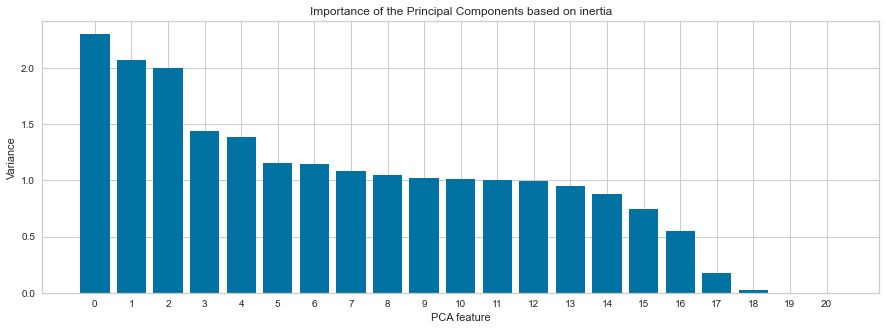

In [35]:
# Standardize/scale the dataset and apply PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
x = bank_clstr
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()


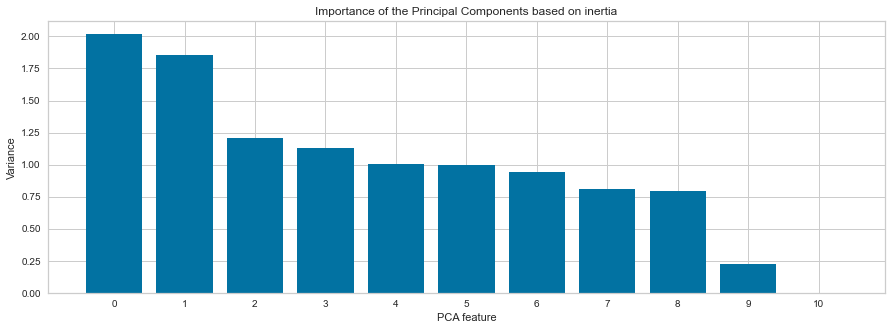

In [36]:
bank_gen = bank_clstr[bank_clstr.columns[:11]]

# Extract the names of the numerical columns
x = bank_gen
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

It turns out that even a data frame without customer columns PCA does not help too much in our case.

In K-Means Clustering approach to anomaly detection we calculate the distance between each point and its nearest centroid and the biggest distances are considered as anomaly. We are going to take following steps:

- We assume a proportion of data as outliers (outliers_fraction: proportion of the outliers present in our data set) and calculate number_of_outliers using outliers_fraction.
- We set a threshold as the minimum distance of these outliers.
- After labeling (0:normal, 1:anomaly) anomalies we will visualize them.

In [37]:
def getDistanceByPoint(data, model):
    """ 
    Function that calculates the distance between a point and centroid of a cluster, 
    returns the distances in pandas series
    """
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

bank_scaled = pd.DataFrame(bank_scaled, columns=bank_clstr.columns)
kmeans = KMeans(n_clusters=5)
kmeans.fit(bank_scaled)
labels = kmeans.predict(bank_scaled)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Assume that 0.5% of the entire data set are anomalies 
outliers_fraction = 0.005
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(bank_scaled, kmeans)
# number of observations that equate to the 0.5% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 0.5% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
bank_scaled['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [38]:
bank_scaled.anomaly_kmeans.value_counts()

0    115620
1       581
Name: anomaly_kmeans, dtype: int64

In [ ]:
labels = bank_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_scaled.iloc[:,3], bank_scaled.iloc[:,4], bank_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'K MEANS ANOMOLIES (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [39]:
bank_main['anomaly_kmeans'] = bank_scaled.anomaly_kmeans

In [ ]:
# bank_main = bank_clstr.copy()
# bank_main['date'], bank_main['value_date'], bank_main['anomaly_kmeans'] = bank_premodel.date, bank_premodel.value_date, bank_scaled.anomaly_kmeans

In [ ]:
features = ['account_no_1196428', 'account_no_1196711', 'account_no_409000362497', 'account_no_409000405747', 'account_no_409000425051', \
            'account_no_409000438611', 'account_no_409000438620', 'account_no_409000493201', 'account_no_409000493210', 'account_no_409000611074']
fig, axes = plt.subplots(5,2, sharex=False, figsize=(18, 18))
fig.suptitle('Anomalies by Account Number', color='r' )

for i in range(5):
    for j in range(2):
        
        df = bank_main[bank_main[features[2*i + j]]==1]
        a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]

        axes[i,j].plot(df['date'], df['balance_amt'], color='blue', label='Normal')
        axes[i,j].scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
        axes[i,j].set_title(f'Anomaly in Balance {features[2*i + j]}')
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Balance amount')
        axes[i,j].legend()

plt.tight_layout()
plt.show()


Let's follow the same process, **but this time customer by customer**. To do this, we will split the bank data frame and run the clustering approach for each individual data frame.

In [40]:
bank_main.columns

Index(['date', 'value_date', 'day_diff', 'weekend_date', 'weekend_value_date',
       'withdrawal_amt', 'deposit_amt', 'balance_amt',
       'withdrawal_over_balance', 'deposit_over_balance',
       'details_null_penalty', 'details_numbers_penalty', 'cheque_penalty',
       'account_no_1196428', 'account_no_1196711', 'account_no_409000362497',
       'account_no_409000405747', 'account_no_409000425051',
       'account_no_409000438611', 'account_no_409000438620',
       'account_no_409000493201', 'account_no_409000493210',
       'account_no_409000611074', 'anomaly_isolation_forest',
       'anomaly_one_class_svm', 'anomaly_gaussian_elliptic_envelope',
       'anomaly_kmeans'],
      dtype='object')

In [41]:
bank_main['anomaly_sum_1'] = bank_main.anomaly_kmeans + bank_main.anomaly_isolation_forest + bank_main.anomaly_one_class_svm + bank_main.anomaly_gaussian_elliptic_envelope
bank_main.anomaly_sum_1.value_counts()

0    114199
1      1534
2       373
3        88
4         7
Name: anomaly_sum_1, dtype: int64

## 4. Anomaly Detection by Account Number

In this section, we will analyze each account number independently.

In [42]:
accounts = ['1196428', '409000362497', '409000438620', '1196711', '409000493210', '409000438611', '409000611074', '409000493201', '409000425051', '409000405747']

acc1, acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9, acc10  = bank_premodel[bank_premodel.account_no== accounts[0]].drop('account_no', axis=1),\
    bank_premodel[bank_premodel.account_no == accounts[1]].drop('account_no', axis=1), bank_premodel[bank_premodel.account_no == accounts[2]].drop('account_no', axis=1),\
    bank_premodel[bank_premodel.account_no == accounts[3]].drop('account_no', axis=1), bank_premodel[bank_premodel.account_no == accounts[4]].drop('account_no', axis=1),\
    bank_premodel[bank_premodel.account_no == accounts[5]].drop('account_no', axis=1), bank_premodel[bank_premodel.account_no == accounts[6]].drop('account_no', axis=1),\
    bank_premodel[bank_premodel.account_no == accounts[7]].drop('account_no', axis=1), bank_premodel[bank_premodel.account_no == accounts[8]].drop('account_no', axis=1),\
    bank_premodel[bank_premodel.account_no == accounts[9]].drop('account_no', axis=1)
df_list = [acc1, acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9, acc10]

### i. Isolation Forest Anomaly Detection

#### &emsp;(I)  Isolation Forest account_no: 1196428

In [43]:
acc1_iso = acc1.copy() 
scaler = StandardScaler()
acc1_iso_scaled = pd.DataFrame(scaler.fit_transform(acc1_iso[acc1.columns[2:]]), columns=acc1.columns[2:])
acc1_iso_scaled.set_index(acc1_iso.index, drop=True, inplace=True)
acc1_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
37582,-0.009703,-0.327498,-0.327574,-0.363895,-0.035259,1.726990,0.362785,0.023566,0.0,-0.089427,0.0
37583,-0.009703,-0.327498,-0.327574,-0.363895,-0.105118,1.743553,0.362785,0.097681,0.0,-0.089427,0.0
37584,-0.009703,-0.327498,-0.327574,-0.363895,-0.242216,1.743863,0.362785,0.243462,0.0,-0.089427,0.0


In [44]:
outliers_fraction = .005
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc1_iso_scaled)

IsolationForest(contamination=0.005)

In [45]:
acc1_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc1_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc1_iso['anomaly_iso'] = acc1_iso_scaled['anomaly_iso']
acc1_iso_scaled['anomaly_iso'].value_counts()

0    48535
1      244
Name: anomaly_iso, dtype: int64

In [46]:
bank_main['iso_1'] = 0
bank_main.loc[acc1_iso_scaled.index,'iso_1'] = acc1_iso_scaled['anomaly_iso']
bank_main['iso_1'].value_counts()

0    115957
1       244
Name: iso_1, dtype: int64

In [ ]:
labels = acc1_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc1_iso_scaled.iloc[:,3], acc1_iso_scaled.iloc[:,4], acc1_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[0]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc1_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[0]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(II)  Isolation Forest account_no: 409000362497

In [47]:
acc2_iso = acc2.copy() 
scaler = StandardScaler()
acc2_iso_scaled = pd.DataFrame(scaler.fit_transform(acc2_iso[acc2.columns[2:]]), columns=acc2.columns[2:])
acc2_iso_scaled.set_index(acc2_iso.index, drop=True, inplace=True)
acc2_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
86361,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.636714,0.286919,-0.990518,3.318566,2.890369,0.0
86362,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.704296,0.286919,-0.999449,3.318566,2.890369,0.0
86363,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.771878,0.286919,-1.008487,3.318566,2.890369,0.0


In [48]:
outliers_fraction = .005
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc2_iso_scaled)

IsolationForest(contamination=0.005)

In [49]:
acc2_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc2_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc2_iso['anomaly_iso'] = acc2_iso_scaled['anomaly_iso']
acc2_iso_scaled['anomaly_iso'].value_counts()

0    29690
1      150
Name: anomaly_iso, dtype: int64

In [50]:
bank_main['iso_2'] = 0
bank_main.loc[acc2_iso_scaled.index,'iso_2'] = acc2_iso_scaled['anomaly_iso']
bank_main['iso_2'].value_counts()

0    116051
1       150
Name: iso_2, dtype: int64

In [ ]:
labels = acc2_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc2_iso_scaled.iloc[:,3], acc2_iso_scaled.iloc[:,4], acc2_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[1]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:

df = acc2_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[1]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(III)  Isolation Forest account_no: 409000438620

In [51]:
acc3_iso = acc3.copy() 
scaler = StandardScaler()
acc3_iso_scaled = pd.DataFrame(scaler.fit_transform(acc3_iso[acc3.columns[2:]]), columns=acc3.columns[2:])
acc3_iso_scaled.set_index(acc3_iso.index, drop=True, inplace=True)
acc3_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
13592,0.0,-0.310493,-0.310493,-0.199596,68.556358,22.083315,0.014814,-55.757387,0.0,-0.008622,-0.024392
13593,0.0,-0.310493,-0.310493,15.416558,-0.161276,17.900179,-114.489398,0.144033,0.0,-0.008622,-0.024392
13594,0.0,-0.310493,-0.310493,-0.199596,1.730729,18.527649,0.014814,-8.139033,0.0,-0.008622,-0.024392


In [52]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc3_iso_scaled)

IsolationForest(contamination=0.01)

In [53]:
acc3_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc3_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc3_iso['anomaly_iso'] = acc3_iso_scaled['anomaly_iso']
acc3_iso_scaled['anomaly_iso'].value_counts()

0    13319
1      135
Name: anomaly_iso, dtype: int64

In [54]:
bank_main['iso_3'] = 0
bank_main.loc[acc3_iso_scaled.index,'iso_3'] = acc3_iso_scaled['anomaly_iso']
bank_main['iso_3'].value_counts()

0    116066
1       135
Name: iso_3, dtype: int64

In [ ]:
labels = acc3_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc3_iso_scaled.iloc[:,3], acc3_iso_scaled.iloc[:,4], acc3_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[2]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc3_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[2]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IV)  Isolation Forest account_no: 1196711

In [55]:
acc4_iso = acc4.copy() 
scaler = StandardScaler()
acc4_iso_scaled = pd.DataFrame(scaler.fit_transform(acc4_iso[acc4.columns[2:]]), columns=acc4.columns[2:])
acc4_iso_scaled.set_index(acc4_iso.index, drop=True, inplace=True)
acc4_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
27046,-0.06111,-0.308943,-0.309496,-0.415321,-0.418209,3.379301,0.37514,0.478891,-0.037759,-0.064759,0.0
27047,-0.06111,-0.308943,-0.309496,-0.415321,-0.418401,3.379311,0.37514,0.479484,-0.037759,-0.064759,0.0
27048,-0.06111,-0.308943,-0.309496,-0.415321,-0.418305,3.379325,0.37514,0.479187,-0.037759,-0.064759,0.0


In [56]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc4_iso_scaled)

IsolationForest(contamination=0.01)

In [57]:
acc4_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc4_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc4_iso['anomaly_iso'] = acc4_iso_scaled['anomaly_iso']
acc4_iso_scaled['anomaly_iso'].value_counts()

0    10432
1      104
Name: anomaly_iso, dtype: int64

In [58]:
bank_main['iso_4'] = 0
bank_main.loc[acc4_iso_scaled.index,'iso_4'] = acc4_iso_scaled['anomaly_iso']
bank_main['iso_4'].value_counts()

0    116097
1       104
Name: iso_4, dtype: int64

In [ ]:
labels = acc4_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc4_iso_scaled.iloc[:,3], acc4_iso_scaled.iloc[:,4], acc4_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[3]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc4_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[3]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(V)  Isolation Forest account_no: 409000493210

In [59]:
acc5_iso = acc5.copy() 
scaler = StandardScaler()
acc5_iso_scaled = pd.DataFrame(scaler.fit_transform(acc5_iso[acc5.columns[2:]]), columns=acc5.columns[2:])
acc5_iso_scaled.set_index(acc5_iso.index, drop=True, inplace=True)
acc5_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
7578,0.0,-0.249713,-0.249713,-0.042609,1.203594,-1.338453,0.041625,-1.140902,0.0,0.0,0.0
7579,0.0,-0.249713,-0.249713,-0.042227,-0.042350,-1.338527,0.041271,0.041689,0.0,0.0,0.0
7580,0.0,-0.249713,-0.249713,-0.042555,-0.042350,-1.338537,0.041575,0.041689,0.0,0.0,0.0


In [60]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc5_iso_scaled)

IsolationForest(contamination=0.01)

In [61]:
acc5_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc5_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc5_iso['anomaly_iso'] = acc5_iso_scaled['anomaly_iso']
acc5_iso_scaled['anomaly_iso'].value_counts()

0    5953
1      61
Name: anomaly_iso, dtype: int64

In [62]:
bank_main['iso_5'] = 0
bank_main.loc[acc5_iso_scaled.index,'iso_5'] = acc5_iso_scaled['anomaly_iso']
bank_main['iso_5'].value_counts()

0    116140
1        61
Name: iso_5, dtype: int64

In [ ]:
labels = acc5_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc5_iso_scaled.iloc[:,3], acc5_iso_scaled.iloc[:,4], acc5_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[4]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc5_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[4]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VI)  Isolation Forest account_no: 409000438611

In [63]:
acc6_iso = acc6.copy() 
scaler = StandardScaler()
acc6_iso_scaled = pd.DataFrame(scaler.fit_transform(acc6_iso[acc6.columns[2:]]), columns=acc6.columns[2:])
acc6_iso_scaled.set_index(acc6_iso.index, drop=True, inplace=True)
acc6_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2990,0.0,-0.280204,-0.280204,-0.217132,52.873839,15.121360,0.149565,-51.360390,0.0,0.0,-0.02954
2991,0.0,-0.280204,-0.280204,27.304861,-0.320477,3.262416,-25.530942,0.318361,0.0,0.0,-0.02954
2992,0.0,-0.280204,-0.280204,8.251173,-0.320477,-0.386490,-5.730111,0.318361,0.0,0.0,-0.02954


In [64]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc6_iso_scaled)

IsolationForest(contamination=0.01)

In [65]:
acc6_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc6_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc6_iso['anomaly_iso'] = acc6_iso_scaled['anomaly_iso']
acc6_iso_scaled['anomaly_iso'].value_counts()

0    4542
1      46
Name: anomaly_iso, dtype: int64

In [66]:
bank_main['iso_6'] = 0
bank_main.loc[acc6_iso_scaled.index,'iso_6'] = acc6_iso_scaled['anomaly_iso']
bank_main['iso_6'].value_counts()

0    116155
1        46
Name: iso_6, dtype: int64

In [ ]:
labels = acc6_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc6_iso_scaled.iloc[:,3], acc6_iso_scaled.iloc[:,4], acc6_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[5]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc6_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[4]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VII)  Isolation Forest account_no: 409000611074

In [67]:
acc7_iso = acc7.copy() 
scaler = StandardScaler()
acc7_iso_scaled = pd.DataFrame(scaler.fit_transform(acc7_iso[acc7.columns[2:]]), columns=acc7.columns[2:])
acc7_iso_scaled.set_index(acc7_iso.index, drop=True, inplace=True)
acc7_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
0,0.0,-0.269481,-0.269481,-0.687913,3.664767,-0.417899,-0.686813,-0.471106,0.0,0.0,0.0
1,0.0,-0.269481,-0.269481,-0.687913,3.664767,0.456234,-0.686813,2.448486,0.0,0.0,0.0
2,0.0,-0.269481,-0.269481,-0.687913,1.550196,0.893301,-0.686813,0.258792,0.0,0.0,0.0


In [68]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc7_iso_scaled)

IsolationForest(contamination=0.01)

In [69]:
acc7_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc7_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc7_iso['anomaly_iso'] = acc7_iso_scaled['anomaly_iso']
acc7_iso_scaled['anomaly_iso'].value_counts()

0    1082
1      11
Name: anomaly_iso, dtype: int64

In [70]:
bank_main['iso_7'] = 0
bank_main.loc[acc7_iso_scaled.index,'iso_7'] = acc7_iso_scaled['anomaly_iso']
bank_main['iso_7'].value_counts()

0    116190
1        11
Name: iso_7, dtype: int64

In [ ]:
labels = acc7_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc7_iso_scaled.iloc[:,3], acc7_iso_scaled.iloc[:,4], acc7_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[6]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc7_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[6]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VIII)  Isolation Forest account_no: 409000493201

In [71]:
acc8_iso = acc8.copy() 
scaler = StandardScaler()
acc8_iso_scaled = pd.DataFrame(scaler.fit_transform(acc8_iso[acc8.columns[2:]]), columns=acc8.columns[2:])
acc8_iso_scaled.set_index(acc8_iso.index, drop=True, inplace=True)
acc8_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
1093,0.0,-0.261873,-0.261873,-0.450731,3.007172,-0.105358,-0.656605,5.540374,0.0,0.0,0.0
1094,0.0,-0.261873,-0.261873,-0.446770,-0.674728,-0.107709,-0.649637,-0.629732,0.0,0.0,0.0
1095,0.0,-0.261873,-0.261873,-0.449547,-0.674728,-0.108412,-0.654521,-0.629732,0.0,0.0,0.0


In [72]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc8_iso_scaled)

IsolationForest(contamination=0.01)

In [73]:
acc8_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc8_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc8_iso['anomaly_iso'] = acc8_iso_scaled['anomaly_iso']
acc8_iso_scaled['anomaly_iso'].value_counts()

0    1033
1      11
Name: anomaly_iso, dtype: int64

In [74]:
bank_main['iso_8'] = 0
bank_main.loc[acc8_iso_scaled.index,'iso_8'] = acc8_iso_scaled['anomaly_iso']
bank_main['iso_8'].value_counts()

0    116190
1        11
Name: iso_8, dtype: int64

In [ ]:
labels = acc8_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc8_iso_scaled.iloc[:,3], acc8_iso_scaled.iloc[:,4], acc8_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[7]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc8_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[7]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IX)  Isolation Forest account_no: 409000425051

In [75]:
acc9_iso = acc9.copy() 
scaler = StandardScaler()
acc9_iso_scaled = pd.DataFrame(scaler.fit_transform(acc9_iso[acc9.columns[2:]]), columns=acc9.columns[2:])
acc9_iso_scaled.set_index(acc9_iso.index, drop=True, inplace=True)
acc9_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2137,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121393,-0.036946,0.619194,0.0,-1.392023,-0.106533
2138,0.0,-0.429695,-0.429695,-0.038344,-0.059793,0.121415,-0.036946,-0.084956,0.0,-1.392023,-0.106533
2139,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121881,-0.036946,0.597977,0.0,-1.392023,-0.106533


In [76]:
outliers_fraction = .01
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc9_iso_scaled)

IsolationForest(contamination=0.01)

In [77]:
acc9_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc9_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc9_iso['anomaly_iso'] = acc9_iso_scaled['anomaly_iso']
acc9_iso_scaled['anomaly_iso'].value_counts()

0    793
1      9
Name: anomaly_iso, dtype: int64

In [78]:
bank_main['iso_9'] = 0
bank_main.loc[acc9_iso_scaled.index,'iso_9'] = acc9_iso_scaled['anomaly_iso']
bank_main['iso_9'].value_counts()

0    116192
1         9
Name: iso_9, dtype: int64

In [ ]:
labels = acc9_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc9_iso_scaled.iloc[:,3], acc9_iso_scaled.iloc[:,4], acc9_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[8]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc9_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[8]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(X)  Isolation Forest account_no: 409000405747

In [79]:
acc10_iso = acc10.copy() 
scaler = StandardScaler()
acc10_iso_scaled = pd.DataFrame(scaler.fit_transform(acc10_iso[acc10.columns[2:]]), columns=acc10.columns[2:])
acc10_iso_scaled.set_index(acc10_iso.index, drop=True, inplace=True)
acc10_iso_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2939,0.0,2.318405,2.318405,5.917619,-0.160336,-0.560995,-6.267844,0.160641,0.0,0.0,0.0
2940,0.0,2.318405,2.318405,0.795991,-0.160336,-0.897240,-0.501724,0.160641,0.0,0.0,0.0
2941,0.0,2.318405,2.318405,-0.296882,-0.160336,-0.898655,0.277847,0.160641,0.0,0.0,0.0


In [80]:
outliers_fraction = .1
model = IsolationForest(contamination=outliers_fraction)
model.fit(acc10_iso_scaled)

IsolationForest(contamination=0.1)

In [81]:
acc10_iso_scaled['anomaly_iso'] = pd.Series(model.predict(acc10_iso_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc10_iso['anomaly_iso'] = acc10_iso_scaled['anomaly_iso']
acc10_iso_scaled['anomaly_iso'].value_counts()

0    46
1     5
Name: anomaly_iso, dtype: int64

In [82]:
bank_main['iso_10'] = 0
bank_main.loc[acc10_iso_scaled.index,'iso_10'] = acc10_iso_scaled['anomaly_iso']
bank_main['iso_10'].value_counts()

0    116196
1         5
Name: iso_10, dtype: int64

In [ ]:
labels = acc10_iso_scaled.anomaly_iso
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc10_iso_scaled.iloc[:,3], acc10_iso_scaled.iloc[:,4], acc10_iso_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ISOLATION FOREST (account_no = {accounts[9]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc10_iso.copy()
a= df.loc[df['anomaly_iso']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[9]} Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [83]:
bank_main['accounts_isolation_forest'] = bank_main.iso_1 + bank_main.iso_2 + bank_main.iso_3 + bank_main.iso_4 + bank_main.iso_5 + bank_main.iso_6 + bank_main.iso_7 + bank_main.iso_8 + bank_main.iso_9 + bank_main.iso_10

In [ ]:
#bank_main.drop(columns=['iso_1', 'iso_2', 'iso_3', 'iso_4', 'iso_5', 'iso_6', 'iso_7', 'iso_8', 'iso_9','iso_10'], axis=1, inplace=True)

In [84]:
bank_main['accounts_isolation_forest'].value_counts()

0    115425
1       776
Name: accounts_isolation_forest, dtype: int64

### ii. OneClassSVM Anomaly Detection

#### &emsp;(I)  OneClassSVM account_no: 1196428

In [85]:
acc1_svm = acc1.copy() 
scaler = StandardScaler()
acc1_svm_scaled = pd.DataFrame(scaler.fit_transform(acc1_svm[acc1.columns[2:]]), columns=acc1.columns[2:])
acc1_svm_scaled.set_index(acc1_svm.index, drop=True, inplace=True)
acc1_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
37582,-0.009703,-0.327498,-0.327574,-0.363895,-0.035259,1.726990,0.362785,0.023566,0.0,-0.089427,0.0
37583,-0.009703,-0.327498,-0.327574,-0.363895,-0.105118,1.743553,0.362785,0.097681,0.0,-0.089427,0.0
37584,-0.009703,-0.327498,-0.327574,-0.363895,-0.242216,1.743863,0.362785,0.243462,0.0,-0.089427,0.0


In [86]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc1_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [87]:
acc1_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc1_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc1_svm['anomaly_svm'] = acc1_svm_scaled['anomaly_svm']
acc1_svm_scaled['anomaly_svm'].value_counts()

0    48533
1      246
Name: anomaly_svm, dtype: int64

In [88]:
bank_main['svm_1'] = 0
bank_main.loc[acc1_svm_scaled.index,'svm_1'] = acc1_svm_scaled['anomaly_svm']
bank_main['svm_1'].value_counts()

0    115955
1       246
Name: svm_1, dtype: int64

In [ ]:
labels = acc1_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc1_svm_scaled.iloc[:,3], acc1_svm_scaled.iloc[:,4], acc1_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[0]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc1_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[0]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(II)  OneClassSVM account_no: 409000362497

In [89]:
acc2_svm = acc2.copy() 
scaler = StandardScaler()
acc2_svm_scaled = pd.DataFrame(scaler.fit_transform(acc2_svm[acc2.columns[2:]]), columns=acc2.columns[2:])
acc2_svm_scaled.set_index(acc2_svm.index, drop=True, inplace=True)
acc2_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
86361,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.636714,0.286919,-0.990518,3.318566,2.890369,0.0
86362,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.704296,0.286919,-0.999449,3.318566,2.890369,0.0
86363,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.771878,0.286919,-1.008487,3.318566,2.890369,0.0


In [90]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc2_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [91]:
acc2_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc2_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc2_svm['anomaly_svm'] = acc2_svm_scaled['anomaly_svm']
acc2_svm_scaled['anomaly_svm'].value_counts()

0    29692
1      148
Name: anomaly_svm, dtype: int64

In [92]:
bank_main['svm_2'] = 0
bank_main.loc[acc2_svm_scaled.index,'svm_2'] = acc2_svm_scaled['anomaly_svm']
bank_main['svm_2'].value_counts()

0    116053
1       148
Name: svm_2, dtype: int64

In [ ]:
labels = acc2_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc2_svm_scaled.iloc[:,3], acc2_svm_scaled.iloc[:,4], acc2_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[1]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc2_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[1]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(III)  OneClassSVM account_no: 409000438620

In [93]:
acc3_svm = acc3.copy() 
scaler = StandardScaler()
acc3_svm_scaled = pd.DataFrame(scaler.fit_transform(acc3_svm[acc3.columns[2:]]), columns=acc3.columns[2:])
acc3_svm_scaled.set_index(acc3_svm.index, drop=True, inplace=True)
acc3_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
13592,0.0,-0.310493,-0.310493,-0.199596,68.556358,22.083315,0.014814,-55.757387,0.0,-0.008622,-0.024392
13593,0.0,-0.310493,-0.310493,15.416558,-0.161276,17.900179,-114.489398,0.144033,0.0,-0.008622,-0.024392
13594,0.0,-0.310493,-0.310493,-0.199596,1.730729,18.527649,0.014814,-8.139033,0.0,-0.008622,-0.024392


In [94]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc3_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [95]:
acc3_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc3_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc3_svm['anomaly_svm'] = acc3_svm_scaled['anomaly_svm']
acc3_svm_scaled['anomaly_svm'].value_counts()

0    13385
1       69
Name: anomaly_svm, dtype: int64

In [96]:
bank_main['svm_3'] = 0
bank_main.loc[acc3_svm_scaled.index,'svm_3'] = acc3_svm_scaled['anomaly_svm']
bank_main['svm_3'].value_counts()

0    116132
1        69
Name: svm_3, dtype: int64

In [ ]:
labels = acc3_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc3_svm_scaled.iloc[:,3], acc3_svm_scaled.iloc[:,4], acc3_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[2]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc3_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[2]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IV)  OneClassSVM account_no: 1196711

In [97]:
acc4_svm = acc4.copy() 
scaler = StandardScaler()
acc4_svm_scaled = pd.DataFrame(scaler.fit_transform(acc4_svm[acc4.columns[2:]]), columns=acc4.columns[2:])
acc4_svm_scaled.set_index(acc4_svm.index, drop=True, inplace=True)
acc4_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
27046,-0.06111,-0.308943,-0.309496,-0.415321,-0.418209,3.379301,0.37514,0.478891,-0.037759,-0.064759,0.0
27047,-0.06111,-0.308943,-0.309496,-0.415321,-0.418401,3.379311,0.37514,0.479484,-0.037759,-0.064759,0.0
27048,-0.06111,-0.308943,-0.309496,-0.415321,-0.418305,3.379325,0.37514,0.479187,-0.037759,-0.064759,0.0


In [98]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc4_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [99]:
acc4_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc4_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc4_svm['anomaly_svm'] = acc4_svm_scaled['anomaly_svm']
acc4_svm_scaled['anomaly_svm'].value_counts()

0    10496
1       40
Name: anomaly_svm, dtype: int64

In [100]:
bank_main['svm_4'] = 0
bank_main.loc[acc4_svm_scaled.index,'svm_4'] = acc4_svm_scaled['anomaly_svm']
bank_main['svm_4'].value_counts()

0    116161
1        40
Name: svm_4, dtype: int64

In [ ]:
labels = acc4_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc4_svm_scaled.iloc[:,3], acc4_svm_scaled.iloc[:,4], acc4_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[3]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc4_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[3]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(V)  OneClassSVM account_no: 409000493210

In [101]:
acc5_svm = acc5.copy() 
scaler = StandardScaler()
acc5_svm_scaled = pd.DataFrame(scaler.fit_transform(acc5_svm[acc5.columns[2:]]), columns=acc5.columns[2:])
acc5_svm_scaled.set_index(acc5_svm.index, drop=True, inplace=True)
acc5_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
7578,0.0,-0.249713,-0.249713,-0.042609,1.203594,-1.338453,0.041625,-1.140902,0.0,0.0,0.0
7579,0.0,-0.249713,-0.249713,-0.042227,-0.042350,-1.338527,0.041271,0.041689,0.0,0.0,0.0
7580,0.0,-0.249713,-0.249713,-0.042555,-0.042350,-1.338537,0.041575,0.041689,0.0,0.0,0.0


In [102]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc5_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [103]:
acc5_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc5_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc5_svm['anomaly_svm'] = acc5_svm_scaled['anomaly_svm']
acc5_svm_scaled['anomaly_svm'].value_counts()

0    5989
1      25
Name: anomaly_svm, dtype: int64

In [104]:
bank_main['svm_5'] = 0
bank_main.loc[acc5_svm_scaled.index,'svm_5'] = acc5_svm_scaled['anomaly_svm']
bank_main['svm_5'].value_counts()

0    116176
1        25
Name: svm_5, dtype: int64

In [ ]:
labels = acc5_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc5_svm_scaled.iloc[:,3], acc5_svm_scaled.iloc[:,4], acc5_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[4]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc5_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[4]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VI)  OneClassSVM account_no: 409000438611

In [105]:
acc6_svm = acc6.copy() 
scaler = StandardScaler()
acc6_svm_scaled = pd.DataFrame(scaler.fit_transform(acc6_svm[acc6.columns[2:]]), columns=acc6.columns[2:])
acc6_svm_scaled.set_index(acc6_svm.index, drop=True, inplace=True)
acc6_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2990,0.0,-0.280204,-0.280204,-0.217132,52.873839,15.121360,0.149565,-51.360390,0.0,0.0,-0.02954
2991,0.0,-0.280204,-0.280204,27.304861,-0.320477,3.262416,-25.530942,0.318361,0.0,0.0,-0.02954
2992,0.0,-0.280204,-0.280204,8.251173,-0.320477,-0.386490,-5.730111,0.318361,0.0,0.0,-0.02954


In [106]:
outliers_fraction = .005
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc6_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.005)

In [107]:
acc6_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc6_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc6_svm['anomaly_svm'] = acc6_svm_scaled['anomaly_svm']
acc6_svm_scaled['anomaly_svm'].value_counts()

0    4559
1      29
Name: anomaly_svm, dtype: int64

In [108]:
bank_main['svm_6'] = 0
bank_main.loc[acc6_svm_scaled.index,'svm_6'] = acc6_svm_scaled['anomaly_svm']
bank_main['svm_6'].value_counts()

0    116172
1        29
Name: svm_6, dtype: int64

In [ ]:
labels = acc6_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc6_svm_scaled.iloc[:,3], acc6_svm_scaled.iloc[:,4], acc6_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[5]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc6_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[5]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VII)  OneClassSVM account_no: 409000611074

In [109]:
acc7_svm = acc7.copy() 
scaler = StandardScaler()
acc7_svm_scaled = pd.DataFrame(scaler.fit_transform(acc7_svm[acc7.columns[2:]]), columns=acc7.columns[2:])
acc7_svm_scaled.set_index(acc7_svm.index, drop=True, inplace=True)
acc7_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
0,0.0,-0.269481,-0.269481,-0.687913,3.664767,-0.417899,-0.686813,-0.471106,0.0,0.0,0.0
1,0.0,-0.269481,-0.269481,-0.687913,3.664767,0.456234,-0.686813,2.448486,0.0,0.0,0.0
2,0.0,-0.269481,-0.269481,-0.687913,1.550196,0.893301,-0.686813,0.258792,0.0,0.0,0.0


In [110]:
outliers_fraction = .01
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc7_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.01)

In [111]:
acc7_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc7_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc7_svm['anomaly_svm'] = acc7_svm_scaled['anomaly_svm']
acc7_svm_scaled['anomaly_svm'].value_counts()

0    1082
1      11
Name: anomaly_svm, dtype: int64

In [112]:
bank_main['svm_7'] = 0
bank_main.loc[acc7_svm_scaled.index,'svm_7'] = acc7_svm_scaled['anomaly_svm']
bank_main['svm_7'].value_counts()

0    116190
1        11
Name: svm_7, dtype: int64

In [ ]:
labels = acc7_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc7_svm_scaled.iloc[:,3], acc7_svm_scaled.iloc[:,4], acc7_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[6]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc7_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[6]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VIII)  OneClassSVM account_no: 409000493201

In [113]:
acc8_svm = acc8.copy() 
scaler = StandardScaler()
acc8_svm_scaled = pd.DataFrame(scaler.fit_transform(acc8_svm[acc8.columns[2:]]), columns=acc8.columns[2:])
acc8_svm_scaled.set_index(acc8_svm.index, drop=True, inplace=True)
acc8_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
1093,0.0,-0.261873,-0.261873,-0.450731,3.007172,-0.105358,-0.656605,5.540374,0.0,0.0,0.0
1094,0.0,-0.261873,-0.261873,-0.446770,-0.674728,-0.107709,-0.649637,-0.629732,0.0,0.0,0.0
1095,0.0,-0.261873,-0.261873,-0.449547,-0.674728,-0.108412,-0.654521,-0.629732,0.0,0.0,0.0


In [114]:
outliers_fraction = .01
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc8_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.01)

In [115]:
acc8_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc8_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc8_svm['anomaly_svm'] = acc8_svm_scaled['anomaly_svm']
acc8_svm_scaled['anomaly_svm'].value_counts()

0    1033
1      11
Name: anomaly_svm, dtype: int64

In [116]:
bank_main['svm_8'] = 0
bank_main.loc[acc8_svm_scaled.index,'svm_8'] = acc8_svm_scaled['anomaly_svm']
bank_main['svm_8'].value_counts()

0    116190
1        11
Name: svm_8, dtype: int64

In [ ]:
labels = acc8_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc8_svm_scaled.iloc[:,3], acc8_svm_scaled.iloc[:,4], acc8_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[7]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc8_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[7]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IX)  OneClassSVM account_no: 409000425051

In [117]:
acc9_svm = acc9.copy() 
scaler = StandardScaler()
acc9_svm_scaled = pd.DataFrame(scaler.fit_transform(acc9_svm[acc9.columns[2:]]), columns=acc9.columns[2:])
acc9_svm_scaled.set_index(acc9_svm.index, drop=True, inplace=True)
acc9_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2137,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121393,-0.036946,0.619194,0.0,-1.392023,-0.106533
2138,0.0,-0.429695,-0.429695,-0.038344,-0.059793,0.121415,-0.036946,-0.084956,0.0,-1.392023,-0.106533
2139,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121881,-0.036946,0.597977,0.0,-1.392023,-0.106533


In [118]:
outliers_fraction = .01
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc9_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.01)

In [119]:
acc9_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc9_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc9_svm['anomaly_svm'] = acc9_svm_scaled['anomaly_svm']
acc9_svm_scaled['anomaly_svm'].value_counts()

0    797
1      5
Name: anomaly_svm, dtype: int64

In [120]:
bank_main['svm_9'] = 0
bank_main.loc[acc9_svm_scaled.index,'svm_9'] = acc9_svm_scaled['anomaly_svm']
bank_main['svm_9'].value_counts()

0    116196
1         5
Name: svm_9, dtype: int64

In [ ]:
labels = acc9_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc9_svm_scaled.iloc[:,3], acc9_svm_scaled.iloc[:,4], acc9_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[8]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc9_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[8]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(X)  OneClassSVM account_no: 409000405747

In [121]:
acc10_svm = acc10.copy() 
scaler = StandardScaler()
acc10_svm_scaled = pd.DataFrame(scaler.fit_transform(acc10_svm[acc10.columns[2:]]), columns=acc10.columns[2:])
acc10_svm_scaled.set_index(acc10_svm.index, drop=True, inplace=True)
acc10_svm_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2939,0.0,2.318405,2.318405,5.917619,-0.160336,-0.560995,-6.267844,0.160641,0.0,0.0,0.0
2940,0.0,2.318405,2.318405,0.795991,-0.160336,-0.897240,-0.501724,0.160641,0.0,0.0,0.0
2941,0.0,2.318405,2.318405,-0.296882,-0.160336,-0.898655,0.277847,0.160641,0.0,0.0,0.0


In [122]:
outliers_fraction = .09
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=.01)
model.fit(acc10_svm_scaled)

OneClassSVM(gamma=0.01, nu=0.09)

In [123]:
acc10_svm_scaled['anomaly_svm'] = pd.Series(model.predict(acc10_svm_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc10_svm['anomaly_svm'] = acc10_svm_scaled['anomaly_svm']
acc10_svm_scaled['anomaly_svm'].value_counts()

0    47
1     4
Name: anomaly_svm, dtype: int64

In [124]:
bank_main['svm_10'] = 0
bank_main.loc[acc10_svm_scaled.index,'svm_10'] = acc10_svm_scaled['anomaly_svm']
bank_main['svm_10'].value_counts()

0    116197
1         4
Name: svm_10, dtype: int64

In [ ]:
labels = acc10_svm_scaled.anomaly_svm
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc10_svm_scaled.iloc[:,3], acc10_svm_scaled.iloc[:,4], acc10_svm_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'ONE CLASS SVM (account_no = {accounts[9]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc10_svm.copy()
a= df.loc[df['anomaly_svm']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[9]} OneClassSVM Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [125]:
bank_main['accounts_SVM'] = bank_main.svm_1 + bank_main.svm_2 + bank_main.svm_3 + bank_main.svm_4 + bank_main.svm_5 + bank_main.svm_6 + bank_main.svm_7 + bank_main.svm_8 + bank_main.svm_9 + bank_main.svm_10

In [126]:
bank_main['accounts_SVM'].value_counts()

0    115613
1       588
Name: accounts_SVM, dtype: int64

### iii. Gaussian Distribution Anomaly Detection (Elliptic Envelope)

#### &emsp;(I)  Gaussian Distribution account_no: 409000405747

In [127]:
acc1_gauss = acc1.copy() 
scaler = StandardScaler()
acc1_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc1_gauss[acc1.columns[2:]]), columns=acc1.columns[2:])
acc1_gauss_scaled.set_index(acc1_gauss.index, drop=True, inplace=True)
acc1_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
37582,-0.009703,-0.327498,-0.327574,-0.363895,-0.035259,1.726990,0.362785,0.023566,0.0,-0.089427,0.0
37583,-0.009703,-0.327498,-0.327574,-0.363895,-0.105118,1.743553,0.362785,0.097681,0.0,-0.089427,0.0
37584,-0.009703,-0.327498,-0.327574,-0.363895,-0.242216,1.743863,0.362785,0.243462,0.0,-0.089427,0.0


In [128]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc1_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [129]:
acc1_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc1_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc1_gauss['anomaly_gauss'] = acc1_gauss_scaled['anomaly_gauss']
acc1_gauss_scaled['anomaly_gauss'].value_counts()

0    48535
1      244
Name: anomaly_gauss, dtype: int64

In [130]:
bank_main['gauss_1'] = 0
bank_main.loc[acc1_gauss_scaled.index,'gauss_1'] = acc1_gauss_scaled['anomaly_gauss']
bank_main['gauss_1'].value_counts()

0    115957
1       244
Name: gauss_1, dtype: int64

In [ ]:
labels = acc1_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc1_gauss_scaled.iloc[:,3], acc1_gauss_scaled.iloc[:,4], acc1_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[0]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc1_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[0]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(II)  Gaussian Distribution account_no: 409000362497

In [131]:
acc2_gauss = acc2.copy() 
scaler = StandardScaler()
acc2_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc2_gauss[acc2.columns[2:]]), columns=acc2.columns[2:])
acc2_gauss_scaled.set_index(acc2_gauss.index, drop=True, inplace=True)
acc2_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
86361,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.636714,0.286919,-0.990518,3.318566,2.890369,0.0
86362,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.704296,0.286919,-0.999449,3.318566,2.890369,0.0
86363,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.771878,0.286919,-1.008487,3.318566,2.890369,0.0


In [132]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc2_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [133]:
acc2_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc2_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc2_gauss['anomaly_gauss'] = acc2_gauss_scaled['anomaly_gauss']
acc2_gauss_scaled['anomaly_gauss'].value_counts()

0    29690
1      150
Name: anomaly_gauss, dtype: int64

In [134]:
bank_main['gauss_2'] = 0
bank_main.loc[acc2_gauss_scaled.index,'gauss_2'] = acc2_gauss_scaled['anomaly_gauss']
bank_main['gauss_2'].value_counts()

0    116051
1       150
Name: gauss_2, dtype: int64

In [ ]:
labels = acc2_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc2_gauss_scaled.iloc[:,3], acc2_gauss_scaled.iloc[:,4], acc2_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[1]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc2_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[1]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(III)  Gaussian Distribution account_no: 409000438620

In [135]:
acc3_gauss = acc3.copy() 
scaler = StandardScaler()
acc3_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc3_gauss[acc3.columns[2:]]), columns=acc3.columns[2:])
acc3_gauss_scaled.set_index(acc3_gauss.index, drop=True, inplace=True)
acc3_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
13592,0.0,-0.310493,-0.310493,-0.199596,68.556358,22.083315,0.014814,-55.757387,0.0,-0.008622,-0.024392
13593,0.0,-0.310493,-0.310493,15.416558,-0.161276,17.900179,-114.489398,0.144033,0.0,-0.008622,-0.024392
13594,0.0,-0.310493,-0.310493,-0.199596,1.730729,18.527649,0.014814,-8.139033,0.0,-0.008622,-0.024392


In [136]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc3_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [137]:
acc3_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc3_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc3_gauss['anomaly_gauss'] = acc3_gauss_scaled['anomaly_gauss']
acc3_gauss_scaled['anomaly_gauss'].value_counts()

0    13386
1       68
Name: anomaly_gauss, dtype: int64

In [138]:
bank_main['gauss_3'] = 0
bank_main.loc[acc3_gauss_scaled.index,'gauss_3'] = acc3_gauss_scaled['anomaly_gauss']
bank_main['gauss_3'].value_counts()

0    116133
1        68
Name: gauss_3, dtype: int64

In [ ]:
labels = acc3_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc3_gauss_scaled.iloc[:,3], acc3_gauss_scaled.iloc[:,4], acc3_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[2]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc3_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[2]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IV)  Gaussian Distribution account_no: 1196711

In [139]:
acc4_gauss = acc4.copy() 
scaler = StandardScaler()
acc4_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc4_gauss[acc4.columns[2:]]), columns=acc4.columns[2:])
acc4_gauss_scaled.set_index(acc4_gauss.index, drop=True, inplace=True)
acc4_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
27046,-0.06111,-0.308943,-0.309496,-0.415321,-0.418209,3.379301,0.37514,0.478891,-0.037759,-0.064759,0.0
27047,-0.06111,-0.308943,-0.309496,-0.415321,-0.418401,3.379311,0.37514,0.479484,-0.037759,-0.064759,0.0
27048,-0.06111,-0.308943,-0.309496,-0.415321,-0.418305,3.379325,0.37514,0.479187,-0.037759,-0.064759,0.0


In [140]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc4_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [141]:
acc4_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc4_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc4_gauss['anomaly_gauss'] = acc4_gauss_scaled['anomaly_gauss']
acc4_gauss_scaled['anomaly_gauss'].value_counts()

0    10476
1       60
Name: anomaly_gauss, dtype: int64

In [142]:
bank_main['gauss_4'] = 0
bank_main.loc[acc4_gauss_scaled.index,'gauss_4'] = acc4_gauss_scaled['anomaly_gauss']
bank_main['gauss_4'].value_counts()

0    116141
1        60
Name: gauss_4, dtype: int64

In [ ]:
labels = acc4_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc4_gauss_scaled.iloc[:,3], acc4_gauss_scaled.iloc[:,4], acc4_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[3]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc4_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[3]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(V)  Gaussian Distribution account_no: 409000493210

In [143]:
acc5_gauss = acc5.copy() 
scaler = StandardScaler()
acc5_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc5_gauss[acc5.columns[2:]]), columns=acc5.columns[2:])
acc5_gauss_scaled.set_index(acc5_gauss.index, drop=True, inplace=True)
acc5_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
7578,0.0,-0.249713,-0.249713,-0.042609,1.203594,-1.338453,0.041625,-1.140902,0.0,0.0,0.0
7579,0.0,-0.249713,-0.249713,-0.042227,-0.042350,-1.338527,0.041271,0.041689,0.0,0.0,0.0
7580,0.0,-0.249713,-0.249713,-0.042555,-0.042350,-1.338537,0.041575,0.041689,0.0,0.0,0.0


In [144]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc5_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [145]:
acc5_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc5_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc5_gauss['anomaly_gauss'] = acc5_gauss_scaled['anomaly_gauss']
acc5_gauss_scaled['anomaly_gauss'].value_counts()

0    5983
1      31
Name: anomaly_gauss, dtype: int64

In [146]:
bank_main['gauss_5'] = 0
bank_main.loc[acc5_gauss_scaled.index,'gauss_5'] = acc5_gauss_scaled['anomaly_gauss']
bank_main['gauss_5'].value_counts()

0    116170
1        31
Name: gauss_5, dtype: int64

In [ ]:
labels = acc5_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc5_gauss_scaled.iloc[:,3], acc5_gauss_scaled.iloc[:,4], acc5_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[4]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc5_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[4]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VI)  Gaussian Distribution account_no: 409000438611

In [147]:
acc6_gauss = acc6.copy() 
scaler = StandardScaler()
acc6_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc6_gauss[acc6.columns[2:]]), columns=acc6.columns[2:])
acc6_gauss_scaled.set_index(acc6_gauss.index, drop=True, inplace=True)
acc6_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2990,0.0,-0.280204,-0.280204,-0.217132,52.873839,15.121360,0.149565,-51.360390,0.0,0.0,-0.02954
2991,0.0,-0.280204,-0.280204,27.304861,-0.320477,3.262416,-25.530942,0.318361,0.0,0.0,-0.02954
2992,0.0,-0.280204,-0.280204,8.251173,-0.320477,-0.386490,-5.730111,0.318361,0.0,0.0,-0.02954


In [148]:
outliers_fraction = .005
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc6_gauss_scaled)

EllipticEnvelope(contamination=0.005)

In [149]:
acc6_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc6_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc6_gauss['anomaly_gauss'] = acc6_gauss_scaled['anomaly_gauss']
acc6_gauss_scaled['anomaly_gauss'].value_counts()

0    4565
1      23
Name: anomaly_gauss, dtype: int64

In [150]:
bank_main['gauss_6'] = 0
bank_main.loc[acc6_gauss_scaled.index,'gauss_6'] = acc6_gauss_scaled['anomaly_gauss']
bank_main['gauss_6'].value_counts()

0    116178
1        23
Name: gauss_6, dtype: int64

In [ ]:
labels = acc6_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc6_gauss_scaled.iloc[:,3], acc6_gauss_scaled.iloc[:,4], acc6_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[5]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc6_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[5]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VII)  Gaussian Distribution account_no: 409000611074

In [151]:
acc7_gauss = acc7.copy() 
scaler = StandardScaler()
acc7_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc7_gauss[acc7.columns[2:]]), columns=acc7.columns[2:])
acc7_gauss_scaled.set_index(acc7_gauss.index, drop=True, inplace=True)
acc7_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
0,0.0,-0.269481,-0.269481,-0.687913,3.664767,-0.417899,-0.686813,-0.471106,0.0,0.0,0.0
1,0.0,-0.269481,-0.269481,-0.687913,3.664767,0.456234,-0.686813,2.448486,0.0,0.0,0.0
2,0.0,-0.269481,-0.269481,-0.687913,1.550196,0.893301,-0.686813,0.258792,0.0,0.0,0.0


In [152]:
outliers_fraction = .01
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc7_gauss_scaled)

EllipticEnvelope(contamination=0.01)

In [153]:
acc7_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc7_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc7_gauss['anomaly_gauss'] = acc7_gauss_scaled['anomaly_gauss']
acc7_gauss_scaled['anomaly_gauss'].value_counts()

0    1082
1      11
Name: anomaly_gauss, dtype: int64

In [154]:
bank_main['gauss_7'] = 0
bank_main.loc[acc7_gauss_scaled.index,'gauss_7'] = acc7_gauss_scaled['anomaly_gauss']
bank_main['gauss_7'].value_counts()

0    116190
1        11
Name: gauss_7, dtype: int64

In [ ]:
labels = acc7_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc7_gauss_scaled.iloc[:,3], acc7_gauss_scaled.iloc[:,4], acc7_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[6]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc7_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[6]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VIII)  Gaussian Distribution account_no: 409000493201

In [155]:
acc8_gauss = acc8.copy() 
scaler = StandardScaler()
acc8_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc8_gauss[acc5.columns[2:]]), columns=acc8.columns[2:])
acc8_gauss_scaled.set_index(acc8_gauss.index, drop=True, inplace=True)
acc8_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
1093,0.0,-0.261873,-0.261873,-0.450731,3.007172,-0.105358,-0.656605,5.540374,0.0,0.0,0.0
1094,0.0,-0.261873,-0.261873,-0.446770,-0.674728,-0.107709,-0.649637,-0.629732,0.0,0.0,0.0
1095,0.0,-0.261873,-0.261873,-0.449547,-0.674728,-0.108412,-0.654521,-0.629732,0.0,0.0,0.0


In [156]:
outliers_fraction = .01
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc8_gauss_scaled)

EllipticEnvelope(contamination=0.01)

In [157]:
acc8_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc8_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc8_gauss['anomaly_gauss'] = acc8_gauss_scaled['anomaly_gauss']
acc8_gauss_scaled['anomaly_gauss'].value_counts()

0    1033
1      11
Name: anomaly_gauss, dtype: int64

In [158]:
bank_main['gauss_8'] = 0
bank_main.loc[acc8_gauss_scaled.index,'gauss_8'] = acc8_gauss_scaled['anomaly_gauss']
bank_main['gauss_8'].value_counts()

0    116190
1        11
Name: gauss_8, dtype: int64

In [ ]:
labels = acc8_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc8_gauss_scaled.iloc[:,3], acc8_gauss_scaled.iloc[:,4], acc8_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[7]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc8_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[7]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IX)  Gaussian Distribution account_no: 409000425051

In [159]:
acc9_gauss = acc9.copy() 
scaler = StandardScaler()
acc9_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc9_gauss[acc9.columns[2:]]), columns=acc9.columns[2:])
acc9_gauss_scaled.set_index(acc9_gauss.index, drop=True, inplace=True)
acc9_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2137,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121393,-0.036946,0.619194,0.0,-1.392023,-0.106533
2138,0.0,-0.429695,-0.429695,-0.038344,-0.059793,0.121415,-0.036946,-0.084956,0.0,-1.392023,-0.106533
2139,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121881,-0.036946,0.597977,0.0,-1.392023,-0.106533


In [160]:
outliers_fraction = .008
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc9_gauss_scaled)

EllipticEnvelope(contamination=0.008)

In [161]:
acc9_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc9_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc9_gauss['anomaly_gauss'] = acc9_gauss_scaled['anomaly_gauss']
acc9_gauss_scaled['anomaly_gauss'].value_counts()

0    795
1      7
Name: anomaly_gauss, dtype: int64

In [162]:
bank_main['gauss_9'] = 0
bank_main.loc[acc9_gauss_scaled.index,'gauss_9'] = acc9_gauss_scaled['anomaly_gauss']
bank_main['gauss_9'].value_counts()

0    116194
1         7
Name: gauss_9, dtype: int64

In [ ]:
labels = acc9_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc9_gauss_scaled.iloc[:,3], acc9_gauss_scaled.iloc[:,4], acc9_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[8]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc9_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[8]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(X)  Gaussian Distribution account_no: 409000405747

In [163]:
acc10_gauss = acc10.copy() 
scaler = StandardScaler()
acc10_gauss_scaled = pd.DataFrame(scaler.fit_transform(acc10_gauss[acc10.columns[2:]]), columns=acc10.columns[2:])
acc10_gauss_scaled.set_index(acc10_gauss.index, drop=True, inplace=True)
acc10_gauss_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2939,0.0,2.318405,2.318405,5.917619,-0.160336,-0.560995,-6.267844,0.160641,0.0,0.0,0.0
2940,0.0,2.318405,2.318405,0.795991,-0.160336,-0.897240,-0.501724,0.160641,0.0,0.0,0.0
2941,0.0,2.318405,2.318405,-0.296882,-0.160336,-0.898655,0.277847,0.160641,0.0,0.0,0.0


In [164]:
outliers_fraction = .08
model = EllipticEnvelope(contamination=outliers_fraction)
model.fit(acc10_gauss_scaled)

EllipticEnvelope(contamination=0.08)

In [165]:
acc10_gauss_scaled['anomaly_gauss'] = pd.Series(model.predict(acc10_gauss_scaled)).apply(lambda x: 0 if x==1 else 1).values
acc10_gauss['anomaly_gauss'] = acc10_gauss_scaled['anomaly_gauss']
acc10_gauss_scaled['anomaly_gauss'].value_counts()

0    46
1     5
Name: anomaly_gauss, dtype: int64

In [166]:
bank_main['gauss_10'] = 0
bank_main.loc[acc10_gauss_scaled.index,'gauss_10'] = acc10_gauss_scaled['anomaly_gauss']
bank_main['gauss_10'].value_counts()

0    116196
1         5
Name: gauss_10, dtype: int64

In [ ]:
labels = acc10_gauss_scaled.anomaly_gauss
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc10_gauss_scaled.iloc[:,3], acc10_gauss_scaled.iloc[:,4], acc10_gauss_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'GAUSSIAN DISTRIBUTION (account_no = {accounts[9]}, outliers_fraction = {100*outliers_fraction}%)', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
df = acc10_gauss.copy()
a= df.loc[df['anomaly_gauss']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[9]} Gaussian Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [167]:
bank_main['accounts_gaussian_distribution'] = bank_main.gauss_1 + bank_main.gauss_2 + bank_main.gauss_3 + bank_main.gauss_4 + bank_main.gauss_5 + bank_main.gauss_6 + bank_main.gauss_7 + bank_main.gauss_8 + bank_main.gauss_9 + bank_main.gauss_10

In [168]:
bank_main['accounts_gaussian_distribution'].value_counts()

0    115591
1       610
Name: accounts_gaussian_distribution, dtype: int64

### iv. KMeans Clustering Anomaly Detection

#### &emsp;(I) Customer account_no_1196428

In [169]:
acc1_kmeans = acc1.copy() 
scaler = StandardScaler()
acc1_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc1_kmeans[acc1.columns[2:]]), columns=acc1.columns[2:])
acc1_kmeans_scaled.set_index(acc1_kmeans.index, drop=True, inplace=True)
acc1_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
37582,-0.009703,-0.327498,-0.327574,-0.363895,-0.035259,1.726990,0.362785,0.023566,0.0,-0.089427,0.0
37583,-0.009703,-0.327498,-0.327574,-0.363895,-0.105118,1.743553,0.362785,0.097681,0.0,-0.089427,0.0
37584,-0.009703,-0.327498,-0.327574,-0.363895,-0.242216,1.743863,0.362785,0.243462,0.0,-0.089427,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc1_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [170]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc1_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc1_kmeans_scaled.iloc[:,3], acc1_kmeans_scaled.iloc[:,4], acc1_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[0]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

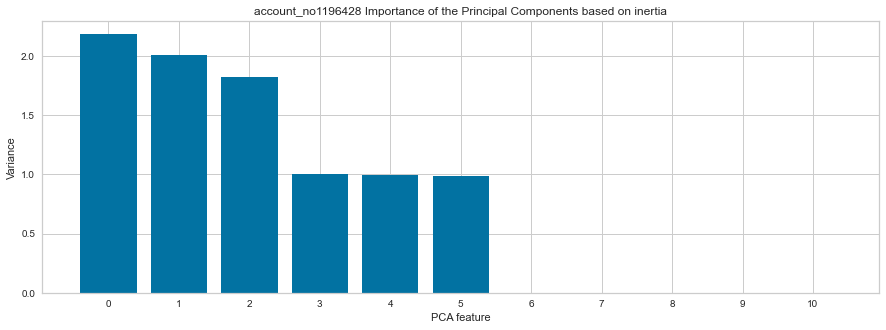

In [171]:
x = acc1_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[0]} Importance of the Principal Components based on inertia")
plt.show()

In [172]:
acc1_pca = pd.DataFrame(PCA(n_components=5).fit_transform(acc1_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5'])

In [173]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc1_pca)
labels = kmeans.predict(acc1_pca)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Assume that 0.5% of the entire data set are anomalies 
outliers_fraction = 0.003
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(acc1_pca, kmeans)
# number of observations that equate to the 0.5%  of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 0.5%  of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
acc1_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [174]:
acc1_pca.index = acc1.index
acc1_pca.anomaly_kmeans.value_counts()

0    48633
1      146
Name: anomaly_kmeans, dtype: int64

In [175]:
acc1_kmeans_scaled['anomaly_kmeans'] = acc1_pca.anomaly_kmeans
bank_main['km_1'] = 0
bank_main.loc[acc1_kmeans_scaled.index,'km_1'] = acc1_kmeans_scaled['anomaly_kmeans']
bank_main['km_1'].value_counts()

0    116055
1       146
Name: km_1, dtype: int64

In [ ]:
labels = acc1_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc1_kmeans_scaled.iloc[:,3], acc1_kmeans_scaled.iloc[:,4], acc1_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[0]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc1_kmeans['anomaly_kmeans'] = acc1_kmeans_scaled['anomaly_kmeans']
df = acc1_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[0]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(II) Customer account_no_409000362497

In [176]:
acc2_kmeans = acc2.copy() 
scaler = StandardScaler()
acc2_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc2_kmeans[acc2.columns[2:]]), columns=acc2.columns[2:])
acc2_kmeans_scaled.set_index(acc2_kmeans.index, drop=True, inplace=True)
acc2_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
86361,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.636714,0.286919,-0.990518,3.318566,2.890369,0.0
86362,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.704296,0.286919,-0.999449,3.318566,2.890369,0.0
86363,-0.020357,-0.286669,-0.286463,-0.297246,1.003038,0.771878,0.286919,-1.008487,3.318566,2.890369,0.0


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

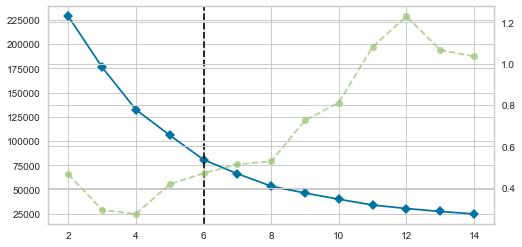

In [177]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc2_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [178]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc2_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc2_kmeans_scaled.iloc[:,3], acc2_kmeans_scaled.iloc[:,4], acc2_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[1]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

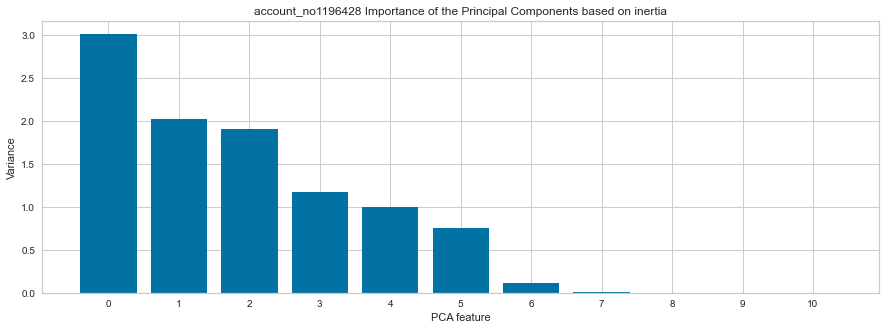

In [179]:
x = acc2_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[0]} Importance of the Principal Components based on inertia")
plt.show()

In [180]:
acc2_pca = pd.DataFrame(PCA(n_components=6).fit_transform(acc2_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5', 'c6'])

In [181]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc2_pca)
labels = kmeans.predict(acc2_pca)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.003
distance = getDistanceByPoint(acc2_pca, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc2_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [182]:
acc2_pca.index = acc2.index
acc2_pca.anomaly_kmeans.value_counts()

0    29751
1       89
Name: anomaly_kmeans, dtype: int64

In [183]:
acc2_kmeans_scaled['anomaly_kmeans'] = acc2_pca.anomaly_kmeans
bank_main['km_2'] = 0
bank_main.loc[acc2_kmeans_scaled.index,'km_2'] = acc2_kmeans_scaled['anomaly_kmeans']
bank_main['km_2'].value_counts()

0    116112
1        89
Name: km_2, dtype: int64

In [ ]:
labels = acc2_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc2_kmeans_scaled.iloc[:,3], acc2_kmeans_scaled.iloc[:,4], acc2_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[1]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc2_kmeans['anomaly_kmeans'] = acc2_kmeans_scaled['anomaly_kmeans']
df = acc2_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[1]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [ ]:
accounts[2]

#### &emsp;(III) Customer account_no_409000438620

In [184]:
acc3_kmeans = acc3.copy() 
scaler = StandardScaler()
acc3_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc3_kmeans[acc3.columns[2:]]), columns=acc3.columns[2:])
acc3_kmeans_scaled.set_index(acc3_kmeans.index, drop=True, inplace=True)
acc3_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
13592,0.0,-0.310493,-0.310493,-0.199596,68.556358,22.083315,0.014814,-55.757387,0.0,-0.008622,-0.024392
13593,0.0,-0.310493,-0.310493,15.416558,-0.161276,17.900179,-114.489398,0.144033,0.0,-0.008622,-0.024392
13594,0.0,-0.310493,-0.310493,-0.199596,1.730729,18.527649,0.014814,-8.139033,0.0,-0.008622,-0.024392


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc3_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [185]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(acc3_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc3_kmeans_scaled.iloc[:,3], acc3_kmeans_scaled.iloc[:,4], acc3_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[2]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

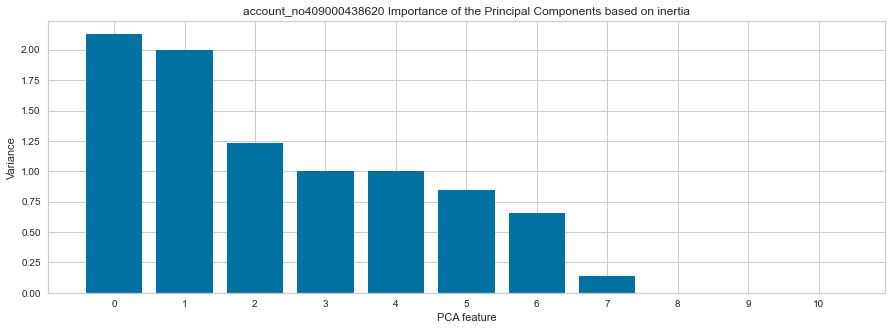

In [186]:
x = acc3_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[2]} Importance of the Principal Components based on inertia")
plt.show()

In [187]:
acc3_pca = pd.DataFrame(PCA(n_components=7).fit_transform(acc3_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5', 'c6', 'c7'])

In [188]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(acc3_pca)
labels = kmeans.predict(acc3_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.003
distance = getDistanceByPoint(acc3_pca, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc3_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [189]:
acc3_pca.index = acc3.index
acc3_pca.anomaly_kmeans.value_counts()

0    13414
1       40
Name: anomaly_kmeans, dtype: int64

In [190]:
acc3_kmeans_scaled['anomaly_kmeans'] = acc3_pca.anomaly_kmeans
bank_main['km_3'] = 0
bank_main.loc[acc3_kmeans_scaled.index,'km_3'] = acc3_kmeans_scaled['anomaly_kmeans']
bank_main['km_3'].value_counts()

0    116161
1        40
Name: km_3, dtype: int64

In [ ]:
labels = acc3_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc3_kmeans_scaled.iloc[:,3], acc3_kmeans_scaled.iloc[:,4], acc3_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[2]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc3_kmeans['anomaly_kmeans'] = acc3_kmeans_scaled['anomaly_kmeans']
df = acc3_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[2]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [ ]:
accounts[3]

#### &emsp;(IV) Customer account_no_1196711

In [191]:
acc4_kmeans = acc4.copy() 
scaler = StandardScaler()
acc4_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc4_kmeans[acc4.columns[2:]]), columns=acc4.columns[2:])
acc4_kmeans_scaled.set_index(acc4_kmeans.index, drop=True, inplace=True)
acc4_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
27046,-0.06111,-0.308943,-0.309496,-0.415321,-0.418209,3.379301,0.37514,0.478891,-0.037759,-0.064759,0.0
27047,-0.06111,-0.308943,-0.309496,-0.415321,-0.418401,3.379311,0.37514,0.479484,-0.037759,-0.064759,0.0
27048,-0.06111,-0.308943,-0.309496,-0.415321,-0.418305,3.379325,0.37514,0.479187,-0.037759,-0.064759,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc4_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [192]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(acc4_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc4_kmeans_scaled.iloc[:,3], acc4_kmeans_scaled.iloc[:,4], acc4_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[3]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

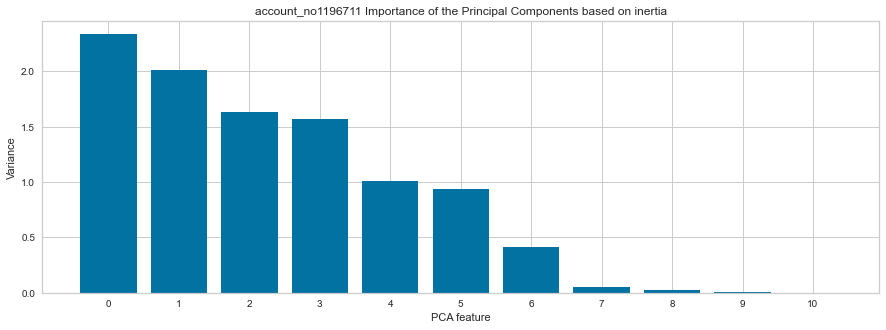

In [193]:
x = acc4_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[3]} Importance of the Principal Components based on inertia")
plt.show()

In [194]:
acc4_pca = pd.DataFrame(PCA(n_components=7).fit_transform(acc4_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5', 'c6', 'c7'])

In [195]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(acc4_pca)
labels = kmeans.predict(acc4_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.005
distance = getDistanceByPoint(acc4_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc4_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [196]:
acc4_pca.index = acc4.index
acc4_pca.anomaly_kmeans.value_counts()

0    10484
1       52
Name: anomaly_kmeans, dtype: int64

In [197]:
acc4_kmeans_scaled['anomaly_kmeans'] = acc4_pca.anomaly_kmeans
bank_main['km_4'] = 0
bank_main.loc[acc4_kmeans_scaled.index,'km_4'] = acc4_kmeans_scaled['anomaly_kmeans']
bank_main['km_4'].value_counts()

0    116149
1        52
Name: km_4, dtype: int64

In [ ]:
labels = acc4_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc4_kmeans_scaled.iloc[:,3], acc4_kmeans_scaled.iloc[:,4], acc4_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[3]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc4_kmeans['anomaly_kmeans'] = acc4_kmeans_scaled['anomaly_kmeans']
df = acc4_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[3]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [ ]:
accounts[4]

#### &emsp;(V) Customer account_no_409000493210

In [198]:
acc5_kmeans = acc5.copy() 
scaler = StandardScaler()
acc5_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc5_kmeans[acc5.columns[2:]]), columns=acc5.columns[2:])
acc5_kmeans_scaled.set_index(acc5_kmeans.index, drop=True, inplace=True)
acc5_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
7578,0.0,-0.249713,-0.249713,-0.042609,1.203594,-1.338453,0.041625,-1.140902,0.0,0.0,0.0
7579,0.0,-0.249713,-0.249713,-0.042227,-0.042350,-1.338527,0.041271,0.041689,0.0,0.0,0.0
7580,0.0,-0.249713,-0.249713,-0.042555,-0.042350,-1.338537,0.041575,0.041689,0.0,0.0,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc5_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [199]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc5_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc5_kmeans_scaled.iloc[:,3], acc5_kmeans_scaled.iloc[:,4], acc5_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[4]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

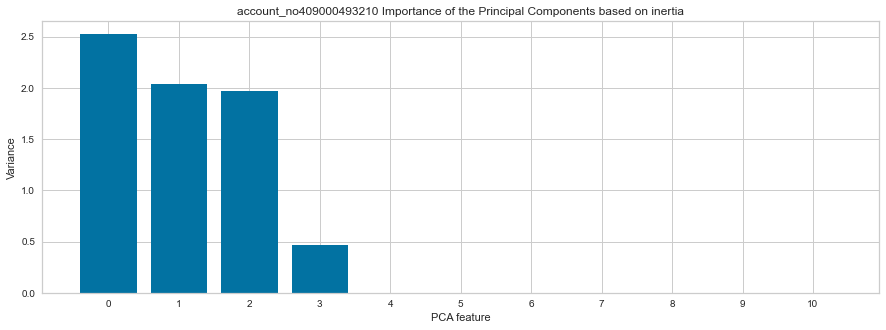

In [200]:
x = acc5_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[4]} Importance of the Principal Components based on inertia")
plt.show()

In [201]:
acc5_pca = pd.DataFrame(PCA(n_components=3).fit_transform(acc5_kmeans_scaled), columns=['c1','c2', 'c3'])

In [202]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc5_pca)
labels = kmeans.predict(acc5_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.005
distance = getDistanceByPoint(acc5_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc5_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [203]:
acc5_pca.index = acc5.index
acc5_pca.anomaly_kmeans.value_counts()

0    5984
1      30
Name: anomaly_kmeans, dtype: int64

In [204]:
acc5_kmeans_scaled['anomaly_kmeans'] = acc5_pca.anomaly_kmeans
bank_main['km_5'] = 0
bank_main.loc[acc5_kmeans_scaled.index,'km_5'] = acc5_kmeans_scaled['anomaly_kmeans']
bank_main['km_5'].value_counts()

0    116171
1        30
Name: km_5, dtype: int64

In [ ]:
labels = acc5_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc5_kmeans_scaled.iloc[:,3], acc5_kmeans_scaled.iloc[:,4], acc5_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[4]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc5_kmeans['anomaly_kmeans'] = acc5_kmeans_scaled['anomaly_kmeans']
df = acc5_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[4]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(V) Customer account_no_409000438611

In [205]:
acc6_kmeans = acc6.copy() 
scaler = StandardScaler()
acc6_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc6_kmeans[acc6.columns[2:]]), columns=acc6.columns[2:])
acc6_kmeans_scaled.set_index(acc6_kmeans.index, drop=True, inplace=True)
acc6_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2990,0.0,-0.280204,-0.280204,-0.217132,52.873839,15.121360,0.149565,-51.360390,0.0,0.0,-0.02954
2991,0.0,-0.280204,-0.280204,27.304861,-0.320477,3.262416,-25.530942,0.318361,0.0,0.0,-0.02954
2992,0.0,-0.280204,-0.280204,8.251173,-0.320477,-0.386490,-5.730111,0.318361,0.0,0.0,-0.02954


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc6_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [206]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(acc6_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc6_kmeans_scaled.iloc[:,3], acc6_kmeans_scaled.iloc[:,4], acc6_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[5]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

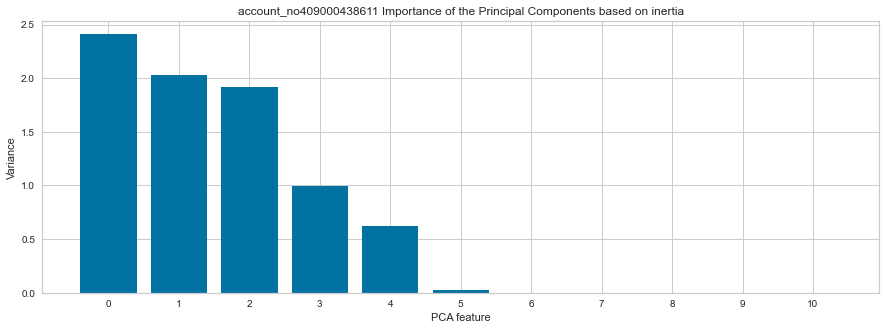

In [207]:
x = acc6_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[5]} Importance of the Principal Components based on inertia")
plt.show()

In [208]:
acc6_pca = pd.DataFrame(PCA(n_components=5).fit_transform(acc6_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5'])

In [209]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(acc6_pca)
labels = kmeans.predict(acc6_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.005
distance = getDistanceByPoint(acc6_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc6_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [210]:
acc6_pca.index = acc6.index
acc6_pca.anomaly_kmeans.value_counts()

0    4566
1      22
Name: anomaly_kmeans, dtype: int64

In [211]:
acc6_kmeans_scaled['anomaly_kmeans'] = acc6_pca.anomaly_kmeans
bank_main['km_6'] = 0
bank_main.loc[acc6_kmeans_scaled.index,'km_6'] = acc6_kmeans_scaled['anomaly_kmeans']
bank_main['km_6'].value_counts()

0    116179
1        22
Name: km_6, dtype: int64

In [ ]:
labels = acc6_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc6_kmeans_scaled.iloc[:,3], acc6_kmeans_scaled.iloc[:,4], acc6_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[5]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc6_kmeans['anomaly_kmeans'] = acc6_kmeans_scaled['anomaly_kmeans']
df = acc6_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[5]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VII) Customer account_no_409000611074

In [212]:
acc7_kmeans = acc7.copy() 
scaler = StandardScaler()
acc7_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc7_kmeans[acc7.columns[2:]]), columns=acc7.columns[2:])
acc7_kmeans_scaled.set_index(acc7_kmeans.index, drop=True, inplace=True)
acc7_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
0,0.0,-0.269481,-0.269481,-0.687913,3.664767,-0.417899,-0.686813,-0.471106,0.0,0.0,0.0
1,0.0,-0.269481,-0.269481,-0.687913,3.664767,0.456234,-0.686813,2.448486,0.0,0.0,0.0
2,0.0,-0.269481,-0.269481,-0.687913,1.550196,0.893301,-0.686813,0.258792,0.0,0.0,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc7_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [213]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(acc7_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc7_kmeans_scaled.iloc[:,3], acc7_kmeans_scaled.iloc[:,4], acc7_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[6]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

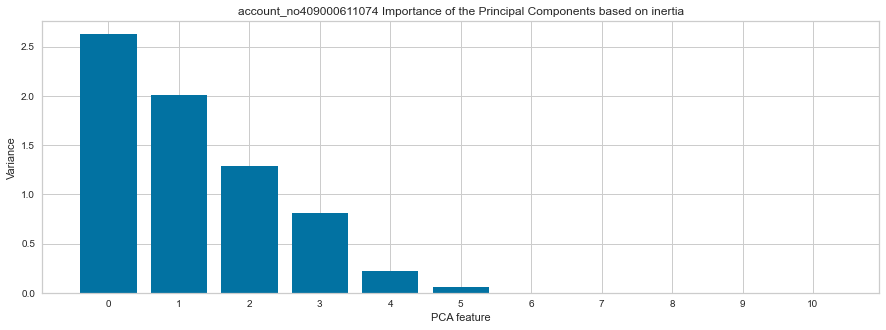

In [214]:
x = acc7_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[6]} Importance of the Principal Components based on inertia")
plt.show()

In [215]:
acc7_pca = pd.DataFrame(PCA(n_components=5).fit_transform(acc7_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5'])

In [216]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(acc7_pca)
labels = kmeans.predict(acc7_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.01
distance = getDistanceByPoint(acc7_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc7_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [217]:
acc7_pca.index = acc7.index
acc7_pca.anomaly_kmeans.value_counts()

0    1083
1      10
Name: anomaly_kmeans, dtype: int64

In [218]:
acc7_kmeans_scaled['anomaly_kmeans'] = acc7_pca.anomaly_kmeans
bank_main['km_7'] = 0
bank_main.loc[acc7_kmeans_scaled.index,'km_7'] = acc7_kmeans_scaled['anomaly_kmeans']
bank_main['km_7'].value_counts()

0    116191
1        10
Name: km_7, dtype: int64

In [ ]:
labels = acc7_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc7_kmeans_scaled.iloc[:,3], acc7_kmeans_scaled.iloc[:,4], acc7_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[6]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc7_kmeans['anomaly_kmeans'] = acc7_kmeans_scaled['anomaly_kmeans']
df = acc7_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[6]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(VIII) Customer account_no_409000493201

In [219]:
acc8_kmeans = acc8.copy() 
scaler = StandardScaler()
acc8_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc8_kmeans[acc8.columns[2:]]), columns=acc8.columns[2:])
acc8_kmeans_scaled.set_index(acc8_kmeans.index, drop=True, inplace=True)
acc8_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
1093,0.0,-0.261873,-0.261873,-0.450731,3.007172,-0.105358,-0.656605,5.540374,0.0,0.0,0.0
1094,0.0,-0.261873,-0.261873,-0.446770,-0.674728,-0.107709,-0.649637,-0.629732,0.0,0.0,0.0
1095,0.0,-0.261873,-0.261873,-0.449547,-0.674728,-0.108412,-0.654521,-0.629732,0.0,0.0,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc8_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [220]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(acc8_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc8_kmeans_scaled.iloc[:,3], acc8_kmeans_scaled.iloc[:,4], acc8_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[7]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

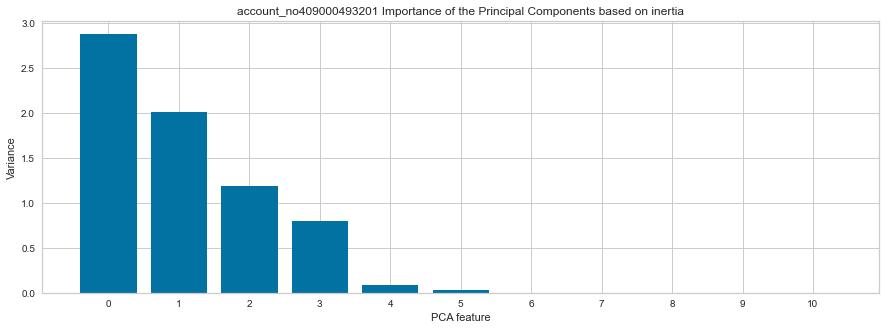

In [221]:
x = acc8_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[7]} Importance of the Principal Components based on inertia")
plt.show()

In [222]:
acc8_pca = pd.DataFrame(PCA(n_components=5).fit_transform(acc8_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5'])

In [223]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(acc8_pca)
labels = kmeans.predict(acc8_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.007
distance = getDistanceByPoint(acc8_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc8_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [224]:
acc8_pca.index = acc8.index
acc8_pca.anomaly_kmeans.value_counts()

0    1037
1       7
Name: anomaly_kmeans, dtype: int64

In [225]:
acc8_kmeans_scaled['anomaly_kmeans'] = acc8_pca.anomaly_kmeans
bank_main['km_8'] = 0
bank_main.loc[acc8_kmeans_scaled.index,'km_8'] = acc8_kmeans_scaled['anomaly_kmeans']
bank_main['km_8'].value_counts()

0    116194
1         7
Name: km_8, dtype: int64

In [ ]:
labels = acc8_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc8_kmeans_scaled.iloc[:,3], acc8_kmeans_scaled.iloc[:,4], acc8_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[7]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc8_kmeans['anomaly_kmeans'] = acc8_kmeans_scaled['anomaly_kmeans']
df = acc8_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[7]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(IX) Customer account_no_409000425051

In [226]:
acc9_kmeans = acc9.copy() 
scaler = StandardScaler()
acc9_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc9_kmeans[acc9.columns[2:]]), columns=acc9.columns[2:])
acc9_kmeans_scaled.set_index(acc9_kmeans.index, drop=True, inplace=True)
acc9_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2137,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121393,-0.036946,0.619194,0.0,-1.392023,-0.106533
2138,0.0,-0.429695,-0.429695,-0.038344,-0.059793,0.121415,-0.036946,-0.084956,0.0,-1.392023,-0.106533
2139,0.0,-0.429695,-0.429695,-0.038344,-0.023229,0.121881,-0.036946,0.597977,0.0,-1.392023,-0.106533


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc9_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [227]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(acc9_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc9_kmeans_scaled.iloc[:,3], acc9_kmeans_scaled.iloc[:,4], acc9_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[8]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

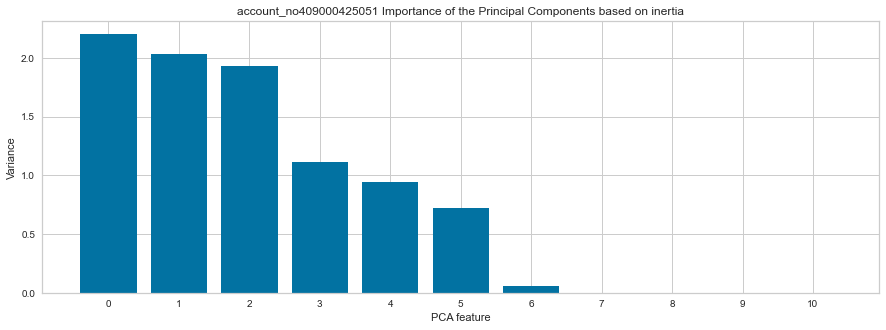

In [228]:
x = acc9_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[8]} Importance of the Principal Components based on inertia")
plt.show()

In [229]:
acc9_pca = pd.DataFrame(PCA(n_components=6).fit_transform(acc9_kmeans_scaled), columns=['c1','c2', 'c3', 'c4', 'c5', 'c6'])

In [230]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(acc9_pca)
labels = kmeans.predict(acc9_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.008
distance = getDistanceByPoint(acc9_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc9_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [231]:
acc9_pca.index = acc9.index
acc9_pca.anomaly_kmeans.value_counts()

0    796
1      6
Name: anomaly_kmeans, dtype: int64

In [232]:
acc9_kmeans_scaled['anomaly_kmeans'] = acc9_pca.anomaly_kmeans
bank_main['km_9'] = 0
bank_main.loc[acc9_kmeans_scaled.index,'km_9'] = acc9_kmeans_scaled['anomaly_kmeans']
bank_main['km_9'].value_counts()

0    116195
1         6
Name: km_9, dtype: int64

In [ ]:
labels = acc9_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc9_kmeans_scaled.iloc[:,3], acc9_kmeans_scaled.iloc[:,4], acc9_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[8]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc9_kmeans['anomaly_kmeans'] = acc9_kmeans_scaled['anomaly_kmeans']
df = acc9_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[8]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

#### &emsp;(X) Customer account_no_409000405747

In [233]:
acc10_kmeans = acc10.copy() 
scaler = StandardScaler()
acc10_kmeans_scaled = pd.DataFrame(scaler.fit_transform(acc10_kmeans[acc10.columns[2:]]), columns=acc10.columns[2:])
acc10_kmeans_scaled.set_index(acc10_kmeans.index, drop=True, inplace=True)
acc10_kmeans_scaled.head(3)

,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
2939,0.0,2.318405,2.318405,5.917619,-0.160336,-0.560995,-6.267844,0.160641,0.0,0.0,0.0
2940,0.0,2.318405,2.318405,0.795991,-0.160336,-0.897240,-0.501724,0.160641,0.0,0.0,0.0
2941,0.0,2.318405,2.318405,-0.296882,-0.160336,-0.898655,0.277847,0.160641,0.0,0.0,0.0


In [ ]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(acc10_kmeans_scaled)       # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [234]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(acc10_kmeans_scaled)
labels = kmeans.labels_

In [ ]:
fig = plt.figure(1, figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc10_kmeans_scaled.iloc[:,3], acc10_kmeans_scaled.iloc[:,4], acc10_kmeans_scaled.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title(f'K MEANS {accounts[9]}', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

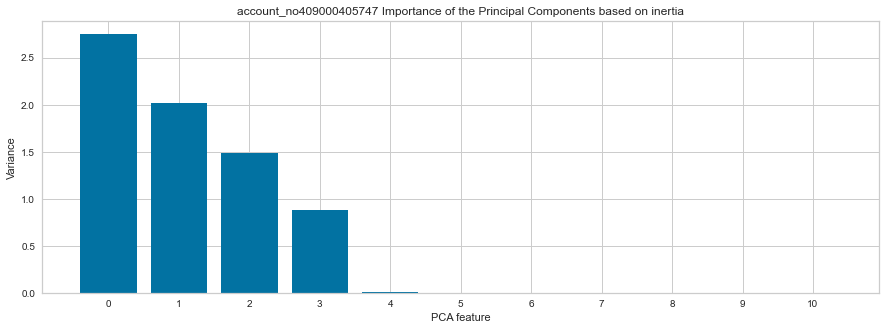

In [235]:
x = acc10_kmeans_scaled
pca = PCA()
pipeline = make_pipeline(pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title(f"account_no{accounts[9]} Importance of the Principal Components based on inertia")
plt.show()

In [236]:
acc10_pca = pd.DataFrame(PCA(n_components=3).fit_transform(acc10_kmeans_scaled), columns=['c1','c2', 'c3'])

In [237]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(acc10_pca)
labels = kmeans.predict(acc10_pca)

unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

outliers_fraction = 0.1
distance = getDistanceByPoint(acc10_pca, kmeans)

number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
acc10_pca['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [238]:
acc10_pca.index = acc10.index
acc10_pca.anomaly_kmeans.value_counts()

0    46
1     5
Name: anomaly_kmeans, dtype: int64

In [239]:
acc10_kmeans_scaled['anomaly_kmeans'] = acc10_pca.anomaly_kmeans
bank_main['km_10'] = 0
bank_main.loc[acc10_kmeans_scaled.index,'km_10'] = acc10_kmeans_scaled['anomaly_kmeans']
bank_main['km_10'].value_counts()

0    116196
1         5
Name: km_10, dtype: int64

In [ ]:
labels = acc10_kmeans_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(acc10_kmeans_scaled.iloc[:,3], acc10_kmeans_scaled.iloc[:,4], acc10_kmeans_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'KMEANS Anomalies account_no = {accounts[9]} (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

In [ ]:
acc10_kmeans['anomaly_kmeans'] = acc10_kmeans_scaled['anomaly_kmeans']
df = acc10_kmeans.copy()
a= df.loc[df['anomaly_kmeans']==1, ['date', 'balance_amt']]
plt.figure(figsize=(20,8))
plt.plot(df['date'], df['balance_amt'], color='blue', label='Normal')
plt.scatter(a['date'], a['balance_amt'], color='red', label='Anomaly')
plt.title(f'{accounts[9]} Kmeans Distribution Anomalies')
plt.xlabel('Date')
plt.ylabel('balance_amt')
plt.legend()
plt.show()

In [240]:
acc1_kmeans['anomaly_kmeans'] = acc1_kmeans_scaled['anomaly_kmeans']
acc2_kmeans['anomaly_kmeans'] = acc2_kmeans_scaled['anomaly_kmeans']
acc3_kmeans['anomaly_kmeans'] = acc3_kmeans_scaled['anomaly_kmeans']
acc4_kmeans['anomaly_kmeans'] = acc4_kmeans_scaled['anomaly_kmeans']
acc5_kmeans['anomaly_kmeans'] = acc5_kmeans_scaled['anomaly_kmeans']
acc6_kmeans['anomaly_kmeans'] = acc6_kmeans_scaled['anomaly_kmeans']
acc7_kmeans['anomaly_kmeans'] = acc7_kmeans_scaled['anomaly_kmeans']
acc8_kmeans['anomaly_kmeans'] = acc8_kmeans_scaled['anomaly_kmeans']
acc9_kmeans['anomaly_kmeans'] = acc9_kmeans_scaled['anomaly_kmeans']
acc10_kmeans['anomaly_kmeans'] = acc10_kmeans_scaled['anomaly_kmeans']

In [241]:
bank_main['accounts_kmeans'] = bank_main.km_1 + bank_main.km_2 + bank_main.km_3 + bank_main.km_4 + bank_main.km_5 + bank_main.km_6 + bank_main.km_7 + bank_main.km_8 + bank_main.km_9 + bank_main.km_10

In [242]:
bank_main['accounts_kmeans'].value_counts()

0    115794
1       407
Name: accounts_kmeans, dtype: int64

In [243]:
bank_main['anomaly_sum_2'] = bank_main.accounts_isolation_forest + bank_main.accounts_SVM + bank_main.accounts_gaussian_distribution + bank_main.accounts_kmeans

## 5. Grading Anomalies

In [244]:
bank_graded = bank_main.copy()

In [245]:
bank_graded['weighted_anomaly'] = bank_graded.anomaly_sum_1 + 2 * bank_graded.anomaly_sum_2
bank_graded['weighted_anomaly'].value_counts()

0     113128
1       1214
2       1002
3        272
4        242
6        116
8         78
5         72
7         36
9         22
10        10
11         6
12         3
Name: weighted_anomaly, dtype: int64

In [246]:
bank_graded['ranks'] =  0

In [247]:
bank_graded.loc[bank_graded.weighted_anomaly>8, 'ranks'] = 1
bank_graded.loc[(bank_graded.weighted_anomaly>4) & (bank_graded.weighted_anomaly<=8),'ranks'] = 2
bank_graded.loc[(bank_graded.weighted_anomaly>2) & (bank_graded.weighted_anomaly<=4), 'ranks'] = 3
bank_graded.ranks.value_counts()

0    115344
3       514
2       302
1        41
Name: ranks, dtype: int64

Since we have essentially determined **weighted_anomaly** using machine learning algorithms, we now want to check some suspicious points that we discovered during the EDA phase. And finally, we synthesize a rank value for each instance.

### day_diff vs. weighted_anomaly

In [248]:
bank_graded[bank_graded.day_diff<0][['day_diff', 'weighted_anomaly', 'ranks']]

,day_diff,weighted_anomaly,ranks
63340,-1,5,2


In [249]:
bank_graded.loc[bank_graded.day_diff<0, 'ranks'] = 1

In [250]:
bank_graded[bank_graded.day_diff>4][['day_diff', 'weighted_anomaly', 'ranks']]

,day_diff,weighted_anomaly,ranks
36647,5,6,2
36648,5,4,3
36727,5,6,2
36728,5,4,3
36892,5,6,2
36893,5,4,3
36894,5,6,2
36915,5,4,3
36916,5,6,2
63717,6,6,2


In [251]:
bank_graded.loc[(bank_graded.day_diff>4) & (bank_graded.day_diff<6) & (bank_graded.ranks==0), 'ranks'] = 3
bank_graded.loc[bank_graded.day_diff>10, 'ranks'] = 1

In [252]:
bank_graded[bank_graded.day_diff>4].ranks.value_counts()

2    7
3    4
1    3
Name: ranks, dtype: int64

### details_null_penalty vs. weighted_anomaly

In [253]:
bank_graded[bank_graded.details_null_penalty>0][['details_null_penalty', 'weighted_anomaly', 'ranks']]

,details_null_penalty,weighted_anomaly,ranks
30345,1,1,0
30346,1,3,3
30584,1,6,2
30585,1,6,2
31192,1,1,0
...,...,...,...
97686,1,0,0
97687,1,0,0
97781,1,0,0
97782,1,0,0


In [254]:
bank_graded[bank_graded.details_null_penalty>0].ranks.value_counts()

0    2362
3     126
2      11
Name: ranks, dtype: int64

### weekend_date vs. weighted_anomaly

In [255]:
bank_graded[bank_graded.weekend_date>0][['weekend_date', 'weekend_value_date', 'weighted_anomaly', 'ranks']]

,weekend_date,weekend_value_date,weighted_anomaly,ranks
117,1,1,3,3
118,1,1,0,0
119,1,1,0,0
120,1,1,0,0
153,1,1,2,0
...,...,...,...,...
116167,1,1,0,0
116168,1,1,0,0
116169,1,1,0,0
116170,1,1,0,0


In [256]:
bank_graded[bank_graded.weekend_date>0].ranks.value_counts()

0    9681
3     284
2      76
1      12
Name: ranks, dtype: int64

In [257]:
bank_graded[bank_graded.weekend_date + bank_graded.weekend_value_date==1][['weekend_date', 'weekend_value_date', 'weighted_anomaly', 'ranks']]

,weekend_date,weekend_value_date,weighted_anomaly,ranks
32528,0,1,3,3
34732,0,1,3,3
35192,0,1,9,1
35798,0,1,3,3
37011,0,1,3,3
37221,1,0,4,3
37222,1,0,9,1
41340,0,1,5,2
54062,0,1,4,3
91948,0,1,5,2


In [258]:
bank_graded.loc[(bank_graded.weekend_date + bank_graded.weekend_value_date==1) & (bank_graded.weekend_date ==1) & (bank_graded.ranks==0), 'ranks'] = 3

In [259]:
bank_graded[bank_graded.weekend_date + bank_graded.weekend_value_date==1].ranks.value_counts()

3    10
2     2
1     2
Name: ranks, dtype: int64

### cheque_penalty vs. weighted_anomaly

In [260]:
bank_graded[bank_graded.cheque_penalty>0][['cheque_penalty', 'weighted_anomaly', 'ranks']]

,cheque_penalty,weighted_anomaly,ranks
2907,1,2,0
2908,1,2,0
2909,1,2,0
2910,1,2,0
2911,1,2,0
2912,1,2,0
2913,1,2,0
2914,1,2,0
2915,1,2,0
5654,1,6,2


In [261]:
bank_graded[bank_graded.cheque_penalty>0].ranks.value_counts()

2    11
0     9
3     1
Name: ranks, dtype: int64

In [ ]:
bank_graded.ranks.value_counts()

## 6. Conclusion

In [262]:
bank_ranked = bank_graded.copy()

In [263]:
drop_lst = ['account_no_1196428', 'account_no_1196711', 'account_no_409000362497', 'account_no_409000405747', 'account_no_409000425051',\
            'account_no_409000438611', 'account_no_409000438620', 'account_no_409000493201', 'account_no_409000493210', 'account_no_409000611074',\
            'anomaly_kmeans', 'anomaly_isolation_forest', 'anomaly_one_class_svm', 'anomaly_gaussian_elliptic_envelope', 'anomaly_sum_1',\
            'accounts_isolation_forest', 'accounts_SVM', 'accounts_gaussian_distribution', 'accounts_kmeans', 'anomaly_sum_2',\
            'iso_1', 'iso_2', 'iso_3', 'iso_4', 'iso_5', 'iso_6', 'iso_7', 'iso_8', 'iso_9', 'iso_10',\
            'svm_1', 'svm_2', 'svm_3', 'svm_4', 'svm_5', 'svm_6', 'svm_7', 'svm_8', 'svm_9', 'svm_10',\
            'gauss_10', 'gauss_2', 'gauss_1', 'gauss_3', 'gauss_4', 'gauss_5', 'gauss_6', 'gauss_7', 'gauss_8', 'gauss_9',\
            'km_1', 'km_2', 'km_3', 'km_4', 'km_5', 'km_6', 'km_7', 'km_8', 'km_9', 'km_10']

bank_ranked.drop(columns=drop_lst, axis=1, inplace=True)

In [264]:
bank_ranked['account_no'] = bank_premodel.account_no

In [265]:
bank_graded['account_no'] = bank_premodel.account_no

In [ ]:
bank_ranked.head()

In [266]:
bank_ranked.to_excel('bank_transaction_ranked.xlsx')

In [271]:
bank_graded['details'] = bank_raw['TRANSACTION DETAILS']

In [272]:
bank_graded.to_excel('bank_transaction_all_grades.xlsx')

In [273]:
bank_ranked[bank_ranked.deposit_over_balance < 0].ranks.value_counts()

0    60631
3      290
2      164
1       16
Name: ranks, dtype: int64

In [274]:
bank_ranked[bank_ranked.ranks > 0]

,date,value_date,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty,weighted_anomaly,ranks,account_no
1,2017-07-05,2017-07-05,0,0,0,0.00,1000000.0,2.000000e+06,0.000000,100.00000,0,0,0,3,3,409000611074
3,2017-08-01,2017-08-01,0,0,0,0.00,3000000.0,5.500000e+06,0.000000,120.00000,0,0,0,11,1,409000611074
9,2017-08-16,2017-08-16,0,0,0,0.00,500000.0,8.500000e+06,0.000000,6.25000,0,0,0,4,3,409000611074
11,2017-08-16,2017-08-16,0,0,0,18000.00,0.0,8.348100e+06,0.215154,0.00000,0,0,0,5,2,409000611074
12,2017-08-16,2017-08-16,0,0,0,5000.00,0.0,8.343100e+06,0.059894,0.00000,0,0,0,5,2,409000611074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107034,2017-08-31,2017-08-28,3,0,0,1493126.69,0.0,-1.900693e+09,-0.078619,0.00000,0,0,0,4,3,409000362497
110119,2017-12-30,2017-12-29,1,1,0,1556161.00,0.0,-1.897862e+09,-0.082063,0.00000,0,0,0,2,3,409000362497
112081,2018-04-27,2018-04-09,18,0,0,9176351.00,0.0,-1.886386e+09,-0.488829,0.00000,0,0,0,6,1,409000362497
113157,2018-06-23,2018-06-22,1,1,0,20500.00,0.0,-1.867826e+09,-0.001098,0.00000,0,0,0,2,3,409000362497
